# See encoder training for `n` epochs below

Test visual encoder prediction speed:

Results reported in the draft in overleaf draft, in section:

Experiments. \subsection{Performance}


In [60]:
# mobed to gradient_walk_utils.py on 12.10.2024, used in the server test_encoder_on_current_position_page

from utils.scripts.architectures.torch_nerf_src import network

import pandas as pd
import torch

def load_model_from_info_dict_path(info_dict_path):
    '''
    Load trained model based on info dictionary.
    '''
    
    # Initialize NeRFS model with weights of trainedNeRF model
    info_dict       = pd.read_json(info_dict_path).to_dict()[0]
    print("Found the following non empty classes:\n\t", info_dict["non_empty_classes_names"])
    # return info_dict
    norm_params     = (torch.tensor(info_dict["xyz_centroid"]), torch.tensor(info_dict["xyz_max-min"]), torch.tensor(info_dict["xyzh_centroid"]), torch.tensor(info_dict["xyzh_max-min"]))

    trained_model_path = info_dict_path.replace(".json", ".pt").replace("training_info", "encoder")
    trained_encoder            = network.nerfs.NeRFS(norm_params=norm_params, surface_type="square", pos_dim=info_dict["enc_input_size"], output_dim=info_dict["num_present_classes"],  view_dir_dim=info_dict["enc_input_size"])
    trained_encoder.load_state_dict(torch.load(trained_model_path))
    
    return trained_encoder, info_dict


info_dict_path = "./utils/assets/data/semantics_final/models/training_info_1000.json"

trained_encoder, info_dict = load_model_from_info_dict_path(info_dict_path)

#Initialize NeRF with placeholder surface:
trained_encoder.surface = network.nerfs.ParametricSurface(torch.tensor([.4,.3,.2]), torch.tensor([.1,.2,.3])\
                                                          , torch.tensor([5.2, 21.3]), "square")


Found the following non empty classes:
	 ['building', 'water', 'road', 'sidewalk', 'surface', 'tree', 'sky', 'miscelaneous']
Constructed tensor formulas: []
Surface not initialized properly. Can only predict from raw position and direction.


In [53]:
from tqdm.notebook import tqdm

torch.random.manual_seed(1)

num_trials = 100000

print("predicting from raw xyz coordinates ")
for i in tqdm(range(num_trials)):
    
    xyz  = torch.randint(0, 2000, (3, ))
    xyzh = torch.randint(0, 180, (3, ))

    _,_, prediction = trained_encoder.predict_from_raw(xyz, xyzh)
    
    
torch.random.manual_seed(1)

print("predicting from subunitary parameters")
for i in tqdm(range(num_trials)):
    
    a  = torch.rand(1)[0]
    b  = torch.rand(1)[0]
    
    xyzh = torch.randint(0, 180, (3, ))

    _,_, prediction = trained_encoder(a, b, xyzh)
    

print(dict(zip(info_dict["non_empty_classes_names"], prediction[0].detach().numpy())))

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

# Method train and save model for `n epochs`

Found 7 classes appearing more than 5.0%: [' building' ' water' ' road ' ' sidewalk' ' surface' ' tree' ' sky']
Training data percentace 100.00% - 27,376 samples, for 1000 epochs:


Epoch 1000 / 1000- Training loss 0.05397 - test loss 0.09718: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [40:26<00:00,  2.43s/it]


Model weights saved at:
	./utils/assets/data/models/encoder_1000.pt

Training for 
	1000     epochs took: 
	2,426s, for an average of: 
	2.4s per epoch.


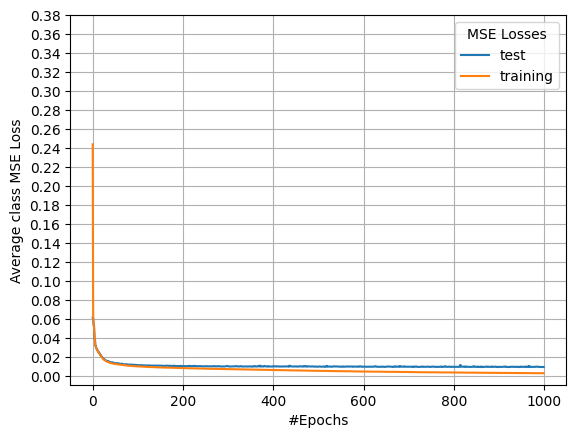

In [1]:
from utils.scripts.architectures.train_location_encoder \
import get_location_visibility_encoder, process_locations_visibility_data_frame\
, get_location_visibility_loaders, run_one_epoch_location_encoder, train_model_on_data

import numpy as np
import pandas as pd
import torch


from tqdm.notebook import tqdm

file_store = "./utils/assets/data/locations_extended.json"
ne=1000
# ne=2
'''
mpc: min_percentage_per_class - 0-1 how often a class should appear in the set to be considered - default .05.
tsp: training set percentage  - out of the 80% of the data on how many samples should the model be trained - default 1.
'''
sli = [0,1,2,3,4,5,6] #[' building' ' water' ' road ' ' sidewalk' ' surface' ' tree' ' sky']
mpc=0.05#0.001
encoder_net, tr_losses_history, test_losses_history, vdf \
= train_model_on_data(data_path=file_store, num_epochs=ne, selected_label_indexes=sli, tsp=1)


import matplotlib.pyplot as plt

# np.array(tlh[0]).mean(axis=1)#, trlh.mean(axis=1)
# tlh[0]#.mean(axis=1)

plt.plot(np.array(test_losses_history).mean(axis=1).repeat(2), label="test")
plt.plot(np.array(tr_losses_history).mean(axis=1), label="training")

plt.legend(title="MSE Losses")

# plt.title(f"NY Data results on predicting: \n{' '.join(non_empty_classes_names)}")
plt.ylabel("Average class MSE Loss")
plt.xlabel("#Epochs")

plt.yticks(np.arange(0, .4, .02))

plt.grid()
plt.show()

In [6]:
"/".join(file_store.split("/")[:-1]+["classes_index.csv"])

'./utils/assets/data/classes_index.csv'

In [4]:
vdf["f_xyz"]

0        [-0.9839611053466797, -0.9888286590576172, -0....
1        [-0.9184818267822266, -0.7804927825927734, -0....
2        [-0.9821109771728516, -0.9887504577636719, -0....
3        [-0.9203281402587891, -0.22628211975097656, -0...
4        [-0.9536361694335938, -0.9968318939208984, -0....
                               ...                        
26227    [-0.3907890319824219, -0.9960842132568359, -0....
26228    [0.9207019805908203, -1.0, -1.0, -0.9207019805...
26229    [-0.34233665466308594, -0.9999599456787109, -0...
26230                              [1.0, -1.0, -1.0, -1.0]
26231    [-0.11776161193847656, -0.9999485015869141, -0...
Name: f_xyz, Length: 26232, dtype: object

# Testing that the loaded model has the reported performance / works well

In [13]:
trained_encoder = torch.load("./data/real_NY/models/encoder_300.pt")
visibility_dataset_df, nec = process_locations_visibility_data_frame("./data/real_NY/locations.csv"\
                                         , min_percentage_per_class=.05, label_split=",")


_, test_loader = get_location_visibility_loaders(processed_vis_loc_df=visibility_dataset_df\
, train_set_percentage=1, test_size=0.2, batch_size=32, pos_enc_dim=10, seed=1)

_, criterion, optimizer, scheduler = get_location_visibility_encoder(10, 4, feat_dim=256)


run_one_epoch_location_encoder(trained_encoder, criterion, optimizer\
                                       , test_loader, training_epoch=False).mean() **.5 \
, run_one_epoch_location_encoder(trained_encoder, criterion, optimizer\
                                       , test_loader, training_epoch=False).mean()


(0.17351630658813638, 0.030107908445449125)

# Time per predictions experiments:

In [3]:
from scripts.architectures.train_location_encoder \
import get_location_visibility_encoder, process_locations_visibility_data_frame\
, get_location_visibility_loaders, run_one_epoch_location_encoder

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

#zooms prediction data frame approach, 25000:
# file_store = "./data/cambridge_block_8_fragment_25000_5_zooms-03-015-005_encoder_locations_v2.csv"
#semantics prediction data frame approach, 12500:
# file_store = "./data/cambridge_block_8_fragment_semantic_locs-2500_dirs-5_visual/locations.csv"


NY_MESH = True
# NY_MESH = False

if NY_MESH:
    
    file_store = "./data/real_NY/locations.csv"
    ins_dict = {c["color"] : c["class"] for c in  \
            pd.read_csv("./data/real_NY/classes_index.csv"\
                        , index_col=False).to_dict(orient="records")
               }
    label_split=","
    classes_names = list(ins_dict.values())
else:
    from scripts.helper_ply_SensatUrban_0 import ins_dict
    label_split=None
    file_store = "./data/cambridge_block_8_fragment_semantic_locs-2500_dirs-5_visual/locations.csv"
    classes_names = list(ins_dict.values())+["empty"]



#1. Read locations.csv and process data frame with normalized coordinate inputs and labels
visibility_dataset_df, nec = process_locations_visibility_data_frame(file_store\
                                         , min_percentage_per_class=.05, label_split=label_split)
non_empty_classes_names                  = np.array(classes_names)[nec]
print(f"Found {nec.sum()} classes: {non_empty_classes_names}")


architecture_size        = 2 ** np.arange(9)[::-1][:-3]
training_set_percentages = np.ones(len(architecture_size))#1 / 2**np.arange(10)#[1, .5, .25, .125, .06]
num_epochs_per_tsp       = (150 * np.ones(len(architecture_size))).astype(int)
# 5 * np.arange(1, 11)**2#10 * np.arange(1, 11) 
print("Training arcitectures with neurons per layer: ", architecture_size)

trlh = []
tlh  = []
ptpn = []

# for i, tsp in enumerate(training_set_percentages):
#2. setup `torch` dataset and loaders
tsp=1; i=0
train_loader, test_loader = get_location_visibility_loaders(processed_vis_loc_df=visibility_dataset_df\
, train_set_percentage=tsp, test_size=0.2, batch_size=32, pos_enc_dim=10)

#3. Setup NeRF-like location encoder:
enc_input_size, num_present_classes          = train_loader.dataset.input_dir.shape[1], train_loader.dataset.output.shape[1]
encoder_net, criterion, optimizer, scheduler =  get_location_visibility_encoder(enc_input_size, num_present_classes, feat_dim=architecture_size[i])
    

Found 4 classes: [' building' ' water' ' tree' ' sky']
Training arcitectures with neurons per layer:  [256 128  64  32  16   8]


In [6]:
train_loader.dataset[:1]

{'input_pos': tensor([[ 0.6419, -0.0020,  0.1269, -0.9693,  0.6923,  0.8985,  0.7668,  1.0000,
           0.9919, -0.2458,  0.7216, -0.4389,  0.9844, -0.0039,  0.2517,  0.4765,
           0.9991, -0.7887,  0.1759,  1.0000,  0.9678, -0.8792,  0.0414, -0.6147,
           0.3463, -0.0079,  0.4873, -0.8378,  0.0828,  0.9697, -0.9381,  1.0000,
           0.8733,  0.5460, -0.9966, -0.2442, -0.6497, -0.0158,  0.8510, -0.9148,
          -0.1650, -0.4737,  0.7601,  0.9999,  0.5252, -0.4038,  0.9863, -0.8807,
          -0.9878, -0.0315,  0.8938,  0.7388, -0.3256,  0.8343,  0.1557,  0.9995,
          -0.4484, -0.6739,  0.9455,  0.5513]]),
 'input_dir': tensor([[-0.3075, -0.0630, -0.8016, -0.9958, -0.6157,  0.9199, -0.9515,  0.9980,
          -0.5978, -0.0918,  0.7880, -0.3922,  0.5852, -0.1258,  0.9585,  0.1828,
          -0.9703, -0.7216,  0.8109,  0.9921, -0.2852, -0.9831,  0.2419, -0.6923,
           0.9491, -0.2495, -0.5468, -0.3595, -0.4694,  0.9991,  0.3150,  0.9684,
          -0.8373,  0.9

In [61]:
2 ** np.arange(15)

array([    1,     2,     4,     8,    16,    32,    64,   128,   256,
         512,  1024,  2048,  4096,  8192, 16384])

In [63]:
from time import time as time
import matplotlib.pyplot as plt


computing_times = []
sample_ids      = []

bs = 20000
ns = len(train_loader.dataset)
# for bs in []
cts = []

bss = 2 ** np.arange(15)

for bs in tqdm(bss):
    for i in (range(100)):
        start_time = time()

        encoder_net(train_loader.dataset[(bs*(i+1))%ns-bs:(bs*(i+1))%ns]["input_pos"]\
                    , train_loader.dataset[(bs*(i+1))%ns-bs:(bs*(i+1))%ns]["input_dir"])

        end_time     = time()
        running_time = (end_time - start_time) / bs
        computing_times.append(running_time)
        sample_ids.append(((bs*(i+1))%ns-bs,(bs*(i+1))%ns))

    cts.append(np.mean(computing_times))

  0%|          | 0/15 [00:00<?, ?it/s]

In [70]:
300 / 20000

0.015

In [131]:
(300 / 20000) / cts[-1] 

328.62424360298894

In [136]:
 (1 / 60 ) * 20000

333.3333333333333

In [137]:
1 / cts[-1]

21908.28290686593

In [138]:
1 / cts[-1] * (1 / 60 )

365.1380484477655

In [135]:
1 / cts[-1] ,  1 / 60, (1 / 60 )

(21908.28290686593, 0.016666666666666666, 0.016666666666666666)

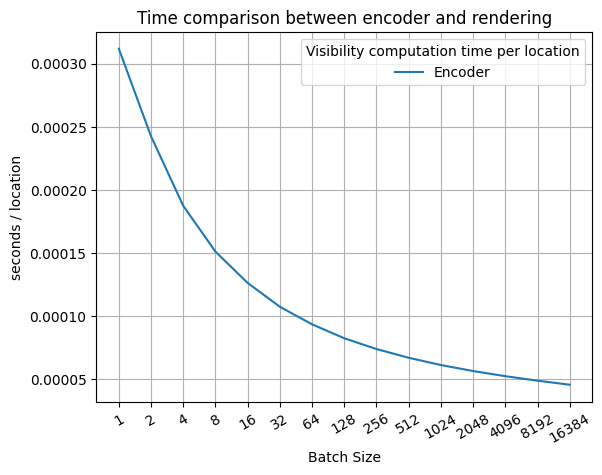

In [128]:
plt.plot(cts, label="Encoder")
plt.xticks(np.arange(len(bss)), bss, rotation=30)
plt.xlabel("Batch Size")
plt.ylabel("seconds / location")
# plt.plot(np.repeat(300 / 800000, len(bss)), linestyle="--", label="Rendering")
# plt.plot(np.repeat(300 / 20000, len(bss)), linestyle="--", label="Rendering")
plt.legend(title="Visibility computation time per location", loc=0)
plt.title("Time comparison between encoder and rendering")
plt.grid()
plt.show()

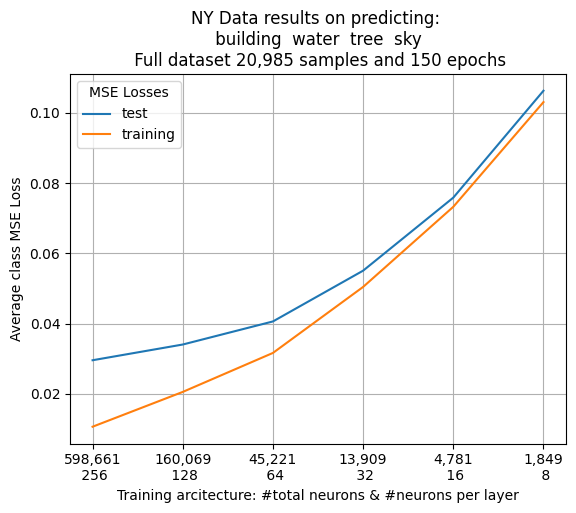

In [14]:
import matplotlib.pyplot as plt
plt.plot([np.mean(t[-1]) for t in tlh], label="test")
plt.plot([np.mean(t[-1]) for t in trlh], label="training")
xtick_labels = (100*training_set_percentages).round(2)#[:-1]

# xtick_labels = [f"{xl}%\n {int(tp):,}\n {nept:,}" for (xl, tp), nept in zip(zip(xtick_labels, training_set_percentages * len(visibility_dataset_df) *.8), num_epochs_per_tsp)]
# xtick_labels = [f"{xl}%\n {int(tp):,}\n {nept:,}" for (xl, tp), nept in zip(zip(xtick_labels, training_set_percentages * len(visibility_dataset_df) *.8), num_epochs_per_tsp)]

training_set_percentages * len(visibility_dataset_df) *.8

train_size = int(training_set_percentages[0] * len(visibility_dataset_df) *.8)

xtick_labels = [f"{p:,}\n {ars}" for (p, ars) in zip(ptpn, architecture_size)]

plt.xticks(np.arange(len(xtick_labels)), xtick_labels, rotation=0)
plt.legend(title="MSE Losses")

plt.title(f"NY Data results on predicting: \n{' '.join(non_empty_classes_names)}"
          f" \n Full dataset {train_size:,} samples and {num_epochs_per_tsp[0]} epochs")
plt.xlabel("Training arcitecture: #total neurons & #neurons per layer")
plt.ylabel("Average class MSE Loss")
plt.grid()
plt.show()

In [54]:
bs, np.mean(computing_times)

(20000, 1.9853341579437256e-07)

In [ ]:
num_samples = len(train_loader.dataset)

In [49]:
2**np.arange(15)

array([    1,     2,     4,     8,    16,    32,    64,   128,   256,
         512,  1024,  2048,  4096,  8192, 16384])

In [50]:
len(train_loader.dataset)

20985

In [46]:
bs, np.mean(computing_times)

(4096, 2.8753012884408233e-07)

In [44]:
bs, np.mean(computing_times)

(2048, 5.089002661406994e-07)

In [42]:
bs, np.mean(computing_times)

(1024, 1.0192231275141239e-06)

In [40]:
bs, np.mean(computing_times)

(512, 2.238745801150799e-06)

In [38]:
bs, np.mean(computing_times)

(256, 5.4056383669376375e-06)

In [36]:
bs, np.mean(computing_times)

(128, 6.3427723944187164e-06)

In [28]:
bs, np.mean(computing_times)

(64, 8.863769471645355e-06)

In [30]:
bs, np.mean(computing_times)

(32, 1.58807635307312e-05)

In [34]:
bs, np.mean(computing_times)

(16, 2.34907865524292e-05)

In [32]:
bs, np.mean(computing_times)

(1, 0.00026193857192993166)

In [16]:
len(train_loader.dataset)

20985

In [7]:
encoder_net(train_loader.dataset[:1]["input_pos"], train_loader.dataset[:1]["input_dir"])

tensor([[-0.0565,  0.0608, -0.0957, -0.0870]], grad_fn=<TanhBackward0>)

# Architecture downcrease experiment loop

In [12]:
from scripts.architectures.train_location_encoder \
import get_location_visibility_encoder, process_locations_visibility_data_frame\
, get_location_visibility_loaders, run_one_epoch_location_encoder

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

#zooms prediction data frame approach, 25000:
# file_store = "./data/cambridge_block_8_fragment_25000_5_zooms-03-015-005_encoder_locations_v2.csv"
#semantics prediction data frame approach, 12500:
# file_store = "./data/cambridge_block_8_fragment_semantic_locs-2500_dirs-5_visual/locations.csv"


NY_MESH = True
# NY_MESH = False

if NY_MESH:
    
    file_store = "./data/real_NY/locations.csv"
    ins_dict = {c["color"] : c["class"] for c in  \
            pd.read_csv("./data/real_NY/classes_index.csv"\
                        , index_col=False).to_dict(orient="records")
               }
    label_split=","
    classes_names = list(ins_dict.values())
else:
    from scripts.helper_ply_SensatUrban_0 import ins_dict
    label_split=None
    file_store = "./data/cambridge_block_8_fragment_semantic_locs-2500_dirs-5_visual/locations.csv"
    classes_names = list(ins_dict.values())+["empty"]



#1. Read locations.csv and process data frame with normalized coordinate inputs and labels
visibility_dataset_df, nec = process_locations_visibility_data_frame(file_store\
                                         , min_percentage_per_class=.05, label_split=label_split)
non_empty_classes_names                  = np.array(classes_names)[nec]
print(f"Found {nec.sum()} classes: {non_empty_classes_names}")


architecture_size        = 2 ** np.arange(9)[::-1][:-3]
training_set_percentages = np.ones(len(architecture_size))#1 / 2**np.arange(10)#[1, .5, .25, .125, .06]
# num_epochs_per_tsp       = (150 * np.ones(len(architecture_size))).astype(int)
num_epochs_per_tsp       = (5 * np.ones(len(architecture_size))).astype(int)
# 5 * np.arange(1, 11)**2#10 * np.arange(1, 11) 
print("Training arcitectures with neurons per layer: ", architecture_size)

trlh = []
tlh  = []
ptpn = []

for i, tsp in enumerate(training_set_percentages):
    #2. setup `torch` dataset and loaders
    train_loader, test_loader = get_location_visibility_loaders(processed_vis_loc_df=visibility_dataset_df\
    , train_set_percentage=tsp, test_size=0.2, batch_size=32, pos_enc_dim=10)

    #3. Setup NeRF-like location encoder:
    enc_input_size, num_present_classes          = train_loader.dataset.input_dir.shape[1], train_loader.dataset.output.shape[1]
    encoder_net, criterion, optimizer, scheduler =  get_location_visibility_encoder(enc_input_size, num_present_classes, feat_dim=architecture_size[i])
    
    #4. Training loop
    num_epochs          = num_epochs_per_tsp[i]
    print(f"Training data percentace {100 * tsp:.2f}% - {int(tsp * len(visibility_dataset_df)*.8):,} samples, for {num_epochs} epochs:")
    pytorch_total_params = sum(p.numel() for p in encoder_net.parameters() if p.requires_grad)
    print(f"NeRF with {pytorch_total_params:,} in total and {architecture_size[i]} neurons per layer.")
    ptpn.append(pytorch_total_params)
    
    training_progress   = tqdm(range(num_epochs))
    logging_steps       = 2#5
    tr_losses_history   = []
    test_losses_history = []
    for epoch in training_progress:

        tr_loss = run_one_epoch_location_encoder(encoder_net, criterion, optimizer\
                                       , train_loader, training_epoch=True)
        tr_losses_history.append(tr_loss)    

        if epoch % logging_steps == 0:

            test_loss = run_one_epoch_location_encoder(encoder_net, criterion, optimizer\
                                       , test_loader, training_epoch=False)
            test_losses_history.append(test_loss)
        
        training_progress.set_description(f'Epoch {epoch +1} / {num_epochs}'+
              f'- Training loss {tr_loss.mean()**.5:.5f} - test loss {test_loss.mean()**.5:.5f}'  )
        
    trlh.append(tr_losses_history)
    tlh.append(test_losses_history)
    break
    
    

Found 4 classes: [' building' ' water' ' tree' ' sky']
Training arcitectures with neurons per layer:  [256 128  64  32  16   8]
Training data percentace 100.00% - 20,985 samples, for 5 epochs:
NeRF with 598,661 in total and 256 neurons per layer.


  0%|          | 0/5 [00:00<?, ?it/s]

In [15]:
encoder_net

NeRF(
  (fc_in): Linear(in_features=60, out_features=8, bias=True)
  (fc_1): Linear(in_features=8, out_features=8, bias=True)
  (fc_2): Linear(in_features=8, out_features=8, bias=True)
  (fc_3): Linear(in_features=8, out_features=8, bias=True)
  (fc_4): Linear(in_features=8, out_features=8, bias=True)
  (fc_5): Linear(in_features=68, out_features=8, bias=True)
  (fc_6): Linear(in_features=8, out_features=8, bias=True)
  (fc_7): Linear(in_features=8, out_features=8, bias=True)
  (fc_8): Linear(in_features=8, out_features=9, bias=True)
  (fc_9): Linear(in_features=68, out_features=4, bias=True)
  (fc_out): Linear(in_features=4, out_features=4, bias=True)
  (relu_actvn): ReLU()
  (sigmoid_actvn): Tanh()
)

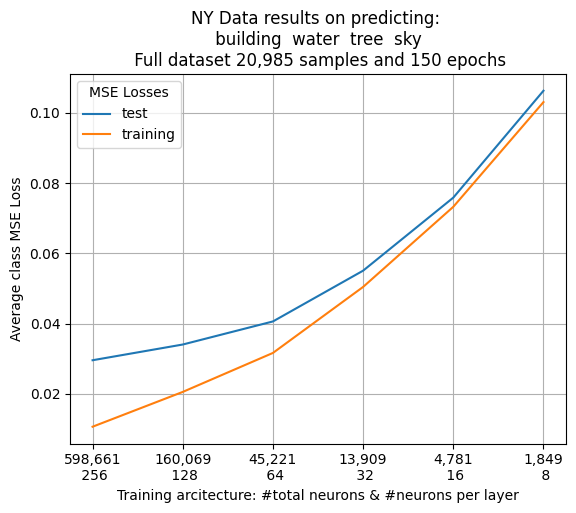

In [14]:
import matplotlib.pyplot as plt
plt.plot([np.mean(t[-1]) for t in tlh], label="test")
plt.plot([np.mean(t[-1]) for t in trlh], label="training")
xtick_labels = (100*training_set_percentages).round(2)#[:-1]

# xtick_labels = [f"{xl}%\n {int(tp):,}\n {nept:,}" for (xl, tp), nept in zip(zip(xtick_labels, training_set_percentages * len(visibility_dataset_df) *.8), num_epochs_per_tsp)]
# xtick_labels = [f"{xl}%\n {int(tp):,}\n {nept:,}" for (xl, tp), nept in zip(zip(xtick_labels, training_set_percentages * len(visibility_dataset_df) *.8), num_epochs_per_tsp)]

training_set_percentages * len(visibility_dataset_df) *.8

train_size = int(training_set_percentages[0] * len(visibility_dataset_df) *.8)

xtick_labels = [f"{p:,}\n {ars}" for (p, ars) in zip(ptpn, architecture_size)]

plt.xticks(np.arange(len(xtick_labels)), xtick_labels, rotation=0)
plt.legend(title="MSE Losses")

plt.title(f"NY Data results on predicting: \n{' '.join(non_empty_classes_names)}"
          f" \n Full dataset {train_size:,} samples and {num_epochs_per_tsp[0]} epochs")
plt.xlabel("Training arcitecture: #total neurons & #neurons per layer")
plt.ylabel("Average class MSE Loss")
plt.grid()
plt.show()

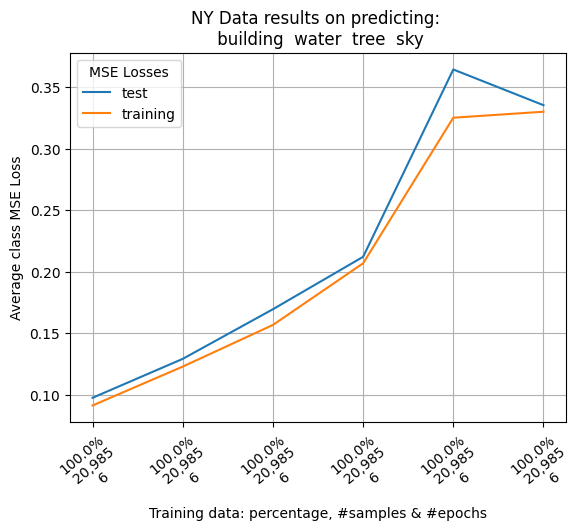

In [3]:
import matplotlib.pyplot as plt
plt.plot([np.mean(t[-1]) for t in tlh], label="test")
plt.plot([np.mean(t[-1]) for t in trlh], label="training")
xtick_labels = (100*training_set_percentages).round(2)#[:-1]

# xtick_labels = [f"{xl}%\n {int(tp):,}\n {nept:,}" for (xl, tp), nept in zip(zip(xtick_labels, training_set_percentages * len(visibility_dataset_df) *.8), num_epochs_per_tsp)]
# xtick_labels = [f"{xl}%\n {int(tp):,}\n {nept:,}" for (xl, tp), nept in zip(zip(xtick_labels, training_set_percentages * len(visibility_dataset_df) *.8), num_epochs_per_tsp)]

xtick_labels = [f"{p:,}\n {ars}\n {nept}" for (p, ars), nept in zip(zip(ptpn, architecture_size), num_epochs_per_tsp)]

plt.xticks(np.arange(len(xtick_labels)), xtick_labels\
           , rotation=40)
plt.legend(title="MSE Losses")

plt.title(f"NY Data results on predicting: \n{' '.join(non_empty_classes_names)}")
plt.xlabel("Training arcitecture: #total neurons, #neurons per layer & #epochs")
plt.ylabel("Average class MSE Loss")
plt.grid()
plt.show()

# Density downcrease experiment loop

In [1]:
from scripts.architectures.train_location_encoder \
import get_location_visibility_encoder, process_locations_visibility_data_frame\
, get_location_visibility_loaders, run_one_epoch_location_encoder

import numpy as np
import pandas as pd

from tqdm.notebook import tqdm

#zooms prediction data frame approach, 25000:
# file_store = "./data/cambridge_block_8_fragment_25000_5_zooms-03-015-005_encoder_locations_v2.csv"
#semantics prediction data frame approach, 12500:
# file_store = "./data/cambridge_block_8_fragment_semantic_locs-2500_dirs-5_visual/locations.csv"


NY_MESH = True
# NY_MESH = False

if NY_MESH:
    
    file_store = "./data/real_NY/locations.csv"
    ins_dict = {c["color"] : c["class"] for c in  \
            pd.read_csv("./data/real_NY/classes_index.csv"\
                        , index_col=False).to_dict(orient="records")
               }
    label_split=","
    classes_names = list(ins_dict.values())
else:
    from scripts.helper_ply_SensatUrban_0 import ins_dict
    label_split=None
    file_store = "./data/cambridge_block_8_fragment_semantic_locs-2500_dirs-5_visual/locations.csv"
    classes_names = list(ins_dict.values())+["empty"]



#1. Read locations.csv and process data frame with normalized coordinate inputs and labels
visibility_dataset_df, nec = process_locations_visibility_data_frame(file_store\
                                         , min_percentage_per_class=.05, label_split=label_split)
non_empty_classes_names                  = np.array(classes_names)[nec]
print(f"Found {nec.sum()} classes: {non_empty_classes_names}")

training_set_percentages = np.ones(1)#1 / 2**np.arange(10)#[1, .5, .25, .125, .06]
# num_epochs_per_tsp       = np.max([5 * np.arange(1, 11)**2, 20*np.ones(10)], axis=0).astype(int)
# num_epochs_per_tsp               = np.max([10 * np.arange(1, 11)**2, 20*np.ones(10)], axis=0).astype(int)
num_epochs_per_tsp               = np.max([10 * np.arange(1, 11)**3, 50*np.ones(10)], axis=0).astype(int)
num_epochs_per_tsp               = np.min([num_epochs_per_tsp, 500*np.ones(10)], axis=0).astype(int)
num_epochs_per_tsp = (150 * np.ones(1)).astype(int)
# 5 * np.arange(1, 11)**2#10 * np.arange(1, 11) 

trlh = []
tlh  = []

for i, tsp in enumerate(training_set_percentages):
    #2. setup `torch` dataset and loaders
    train_loader, test_loader = get_location_visibility_loaders(processed_vis_loc_df=visibility_dataset_df\
    , train_set_percentage=tsp, test_size=0.2, batch_size=32, pos_enc_dim=10)

    #3. Setup NeRF-like location encoder:
    enc_input_size, num_present_classes          = train_loader.dataset.input_dir.shape[1], train_loader.dataset.output.shape[1]
    encoder_net, criterion, optimizer, scheduler =  get_location_visibility_encoder(enc_input_size, num_present_classes)

    #4. Training loop
    num_epochs          = num_epochs_per_tsp[i]
    print(f"Training data percentace {100 * tsp:.2f}% - {int(tsp * len(visibility_dataset_df)*.8):,} samples, for {num_epochs} epochs:")
    training_progress   = tqdm(range(num_epochs))
    logging_steps       = 2#5
    tr_losses_history   = []
    test_losses_history = []
    for epoch in training_progress:

        tr_loss = run_one_epoch_location_encoder(encoder_net, criterion, optimizer\
                                       , train_loader, training_epoch=True)
        tr_losses_history.append(tr_loss)    

        if epoch % logging_steps == 0:

            test_loss = run_one_epoch_location_encoder(encoder_net, criterion, optimizer\
                                       , test_loader, training_epoch=False)
            test_losses_history.append(test_loss)
        
        training_progress.set_description(f'Epoch {epoch +1} / {num_epochs}'+
              f'- Training loss {tr_loss.mean()**.5:.5f} - test loss {test_loss.mean()**.5:.5f}'  )
        
    trlh.append(tr_losses_history)
    tlh.append(test_losses_history)
    
    

Found 4 classes: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 20,985 samples, for 150 epochs:


  0%|          | 0/150 [00:00<?, ?it/s]

KeyboardInterrupt: 

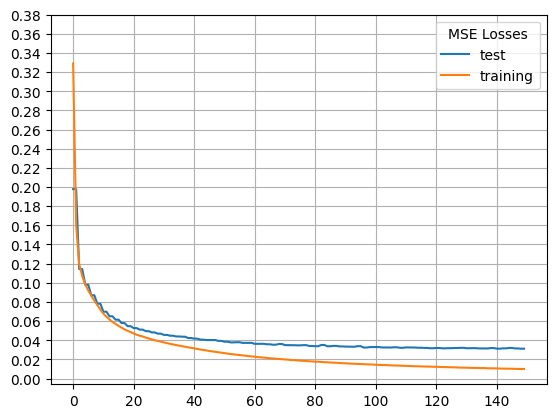

In [3]:
import matplotlib.pyplot as plt

# np.array(tlh[0]).mean(axis=1)#, trlh.mean(axis=1)
# tlh[0]#.mean(axis=1)

plt.plot(np.array(tlh[0]).mean(axis=1).repeat(logging_steps), label="test")
plt.plot(np.array(trlh[0]).mean(axis=1), label="training")

plt.legend(title="MSE Losses")

plt.yticks(np.arange(0, .4, .02))

plt.grid()
plt.show()

In [2]:
pytorch_total_params = sum(p.numel() for p in encoder_net.parameters() if p.requires_grad)

pytorch_total_params

598661

In [4]:
outputs_ser            = []
labels_ser            = []
image_name_ser         = []
latent_output_ser      = []
set_type_ser           = []

for i, sample_batch in tqdm(enumerate(train_loader)):
        
    input_pos = sample_batch["input_pos"]
    input_dir = sample_batch["input_dir"]
    labels    = sample_batch["output"]
    image_name = sample_batch["image_name"]


    output, latent_output = encoder_net.get_latent_feature(input_pos, input_dir)
    
    outputs_ser.append(output.detach().numpy())
    labels_ser.append(labels.detach().numpy())
    image_name_ser.append(image_name)
    latent_output_ser.append(latent_output.detach().numpy())   
    set_type_ser.append(np.repeat(["train"], latent_output.detach().numpy().shape[0])) 
    
    
for i, sample_batch in tqdm(enumerate(test_loader)):
        
    input_pos = sample_batch["input_pos"]
    input_dir = sample_batch["input_dir"]
    labels    = sample_batch["output"]
    image_name = sample_batch["image_name"]

    output, latent_output = encoder_net.get_latent_feature(input_pos, input_dir)
    
    outputs_ser.append(output.detach().numpy())
    labels_ser.append(labels.detach().numpy())
    image_name_ser.append(image_name)
    latent_output_ser.append(latent_output.detach().numpy())
    set_type_ser.append(np.repeat(["test"], latent_output.detach().numpy().shape[0]))
    
    #pass

# image_name, output, latent_output

latent_space_df = pd.DataFrame([np.hstack(image_name_ser), np.vstack(labels_ser), np.vstack(outputs_ser)\
              , np.vstack(latent_output_ser), np.hstack(set_type_ser)]).T

latent_space_df.columns = ['image_name', "gt_label-"+"_".join(non_empty_classes_names).replace(" ", ""), "enc_output"\
                           , "enc_latent_output", "set_type"]


latent_space_df

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,image_name,gt_label-building_water_tree_sky,enc_output,enc_latent_output,set_type
0,pos871-0-visibility-20,"[-0.62106895, -0.4942627, -0.90792847, -0.0701...","[-0.6803382, -0.50343394, -0.8487577, -0.09031...","[0.0, 0.05645074, 0.1611912, 0.0, 0.26462126, ...",train
1,pos1761-1-visibility-20,"[0.8604126, -1.0, -0.95399284, -0.957304]","[0.76418334, -0.99929017, -0.8965334, -0.909994]","[0.0, 0.04068195, 0.013784998, 0.0, 0.01798428...",train
2,pos585-1-visibility-20,"[1.0, -1.0, -1.0, -1.0]","[0.8699788, -0.9995357, -0.9435028, -0.96198136]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.8576152, 0.0, 0.0,...",train
3,pos966-3-visibility-20,"[0.42208672, -1.0, -1.0, -0.42208672]","[0.41888648, -0.9998624, -0.89315665, -0.5669927]","[0.0, 0.072364196, 0.04479144, 0.0, 0.0, 1.628...",train
4,pos1357-1-visibility-70,"[-0.59163475, -0.9995594, -0.2007904, -0.51387...","[-0.5732458, -0.9560747, -0.20600297, -0.6474988]","[0.0, 0.38239807, 0.3367104, 0.0, 0.0, 0.75995...",train
...,...,...,...,...,...
26227,pos1208-4-visibility-70,"[-0.8053932, -0.99819946, -0.54403496, 0.21319...","[-0.7685321, -0.99341434, -0.4744971, 0.10811591]","[0.0, 0.4205606, 0.68048406, 0.0, 0.0, 1.12821...",test
26228,pos563-0-visibility-70,"[0.95594406, -1.0, -1.0, -0.95594406]","[0.94378906, -0.999996, -0.99632436, -0.9581812]","[0.0, 0.0, 0.22625057, 0.0, 0.0, 2.6005542, 0....",test
26229,pos1839-1-visibility-20,"[0.86058044, -1.0, -0.86120415, -0.9993763]","[0.93678635, -0.9999044, -0.96892214, -0.9836345]","[0.0, 0.0, 0.0, 0.0, 0.0, 2.0326035, 0.0, 0.0,...",test
26230,pos57-5-visibility-20,"[-0.8014221, -0.21059418, -0.7624359, -0.25933...","[-0.8775895, -0.34253776, -0.72970426, -0.1741...","[0.32952687, 0.0, 0.07726899, 0.0, 0.0, 0.2960...",test


In [5]:
latent_annotated_df = pd.merge(visibility_dataset_df, latent_space_df, on="image_name")

latent_annotated_df = latent_annotated_df.drop(columns=["f_xyz", "xn", "yn", "zn", "xhn", "yhn", "zhn"], axis=1)

# latent_annotated_df[latent_annotated_df["set_type"]=="test"]

latent_annotated_df.head()

,x,y,z,xh,yh,zh,image_name,f_xyz_raw,gt_label-building_water_tree_sky,enc_output,enc_latent_output,set_type
0,592.664199,51.652981,104.63469,170.357425,4.103539,-179.303432,pos0-0-visibility-20,"[8409, 5857, 0, 743, 6027, 275462, 752078, 0]","[-0.9839611, -0.98882866, -0.47459793, 0.43447...","[-0.93673795, -0.90106034, -0.51105666, 0.3730...","[0.0, 0.36311772, 0.1576694, 0.0, 0.0, 0.35391...",test
1,592.664199,101.652981,104.63469,172.557271,4.127195,-179.461323,pos0-0-visibility-70,"[42739, 115085, 42, 2893, 9298, 95965, 782554, 0]","[-0.9184818, -0.7804928, -0.8169613, 0.4926033]","[-0.8327569, -0.838405, -0.764027, 0.4505774]","[0.0, 0.61368716, 0.29165038, 0.0, 0.25547856,...",train
2,592.664199,51.652981,104.63469,-179.925623,4.162137,179.994602,pos0-1-visibility-20,"[9379, 5898, 0, 57301, 222187, 284301, 469510, 0]","[-0.982111, -0.98875046, -0.45773888, -0.10448...","[-0.9360678, -0.8930559, -0.05846448, -0.08233...","[0.0, 0.13677314, 0.05260016, 0.0, 0.0, 0.6702...",test
3,592.664199,101.652981,104.63469,-177.677119,4.158732,179.831453,pos0-1-visibility-70,"[41771, 405651, 54, 2807, 8688, 91920, 497685, 0]","[-0.92032814, -0.22628212, -0.8246765, -0.0507...","[-0.84522897, -0.30446276, -0.6693068, -0.1744...","[0.24851601, 0.3375145, 0.1142182, 0.0, 0.0, 0...",train
4,592.664199,51.652981,104.63469,179.685299,-12.968808,179.929374,pos0-2-visibility-20,"[24308, 1661, 0, 83574, 174787, 298824, 465422...","[-0.95363617, -0.9968319, -0.43003845, -0.1122...","[-0.84486663, -0.94250935, -0.13069354, -0.113...","[0.0, 0.26063597, 0.24516045, 0.0, 0.0, 0.8152...",train


In [129]:
file_store.strip(".csv") + "s-latent_encoder_annotated.csv"

'/data/real_NY/locations-latent_encoder_annotated.csv'

In [6]:
annotated_file_path = "." + file_store.strip(".csv") + "s-latent_encoder_annotated.csv"

latent_annotated_df.to_csv(annotated_file_path, index=False)

print(f"Encoded annotated data frame saved at: \n\t{annotated_file_path}")

pd.read_csv("./data/real_NY/locations-latent_encoder_annotated.csv").head()

Encoded annotated data frame saved at: 
	./data/real_NY/locations-latent_encoder_annotated.csv


,x,y,z,xh,yh,zh,image_name,f_xyz_raw,gt_label-building_water_tree_sky,enc_output,enc_latent_output,set_type
0,592.664199,51.652981,104.63469,170.357425,4.103539,-179.303432,pos0-0-visibility-20,"[8409, 5857, 0, 743, 6027, 275462, 752078, 0]",[-0.9839611 -0.98882866 -0.47459793 0.43447495],[-0.93673795 -0.90106034 -0.51105666 0.37307957],[0. 0.36311772 0.1576694 0. 0...,test
1,592.664199,101.652981,104.63469,172.557271,4.127195,-179.461323,pos0-0-visibility-70,"[42739, 115085, 42, 2893, 9298, 95965, 782554, 0]",[-0.9184818 -0.7804928 -0.8169613 0.4926033],[-0.8327569 -0.838405 -0.764027 0.4505774],[0. 0.61368716 0.29165038 0. 0...,train
2,592.664199,51.652981,104.63469,-179.925623,4.162137,179.994602,pos0-1-visibility-20,"[9379, 5898, 0, 57301, 222187, 284301, 469510, 0]",[-0.982111 -0.98875046 -0.45773888 -0.10448074],[-0.9360678 -0.8930559 -0.05846448 -0.08233715],[0. 0.13677314 0.05260016 0. 0...,test
3,592.664199,101.652981,104.63469,-177.677119,4.158732,179.831453,pos0-1-visibility-70,"[41771, 405651, 54, 2807, 8688, 91920, 497685, 0]",[-0.92032814 -0.22628212 -0.8246765 -0.0507412 ],[-0.84522897 -0.30446276 -0.6693068 -0.17448969],[0.24851601 0.3375145 0.1142182 0. 0...,train
4,592.664199,51.652981,104.63469,179.685299,-12.968808,179.929374,pos0-2-visibility-20,"[24308, 1661, 0, 83574, 174787, 298824, 465422...",[-0.95363617 -0.9968319 -0.43003845 -0.11227798],[-0.84486663 -0.94250935 -0.13069354 -0.11377002],[0. 0.26063597 0.24516045 0. 0...,train


# Dominant Class evaluation

In [121]:
print("Overall Dominant Class predicition accuracy:")
print("\t", (latent_annotated_df["gt_label-building_water_tree_sky"].apply(np.argmax) == \
latent_annotated_df["enc_output"].apply(np.argmax)).sum() / latent_annotated_df.shape[0])

print("\nTraining Dominant Class predicition accuracy:")
print("\t", (latent_annotated_df[latent_annotated_df["set_type"]=="train"]["gt_label-building_water_tree_sky"].apply(np.argmax) == \
latent_annotated_df[latent_annotated_df["set_type"]=="train"]["enc_output"].apply(np.argmax)).sum() \
/ latent_annotated_df[latent_annotated_df["set_type"]=="train"].shape[0])

print("\nTesting Dominant Class predicition accuracy:")
print("\t", (latent_annotated_df[latent_annotated_df["set_type"]=="test"]["gt_label-building_water_tree_sky"].apply(np.argmax) == \
latent_annotated_df[latent_annotated_df["set_type"]=="test"]["enc_output"].apply(np.argmax)).sum() \
/ latent_annotated_df[latent_annotated_df["set_type"]=="test"].shape[0])

Overall Dominant Class predicition accuracy:
	 0.9106053674900885

Training Dominant Class predicition accuracy:
	 0.9163688348820586

Testing Dominant Class predicition accuracy:
	 0.8875547932151706


In [113]:
print("Training Dominant Class predicition accuracy:")

print("\t", (latent_annotated_df[latent_annotated_df["set_type"]=="train"]["gt_label-building_water_tree_sky"].apply(np.argmax) == \
latent_annotated_df[latent_annotated_df["set_type"]=="train"]["enc_output"].apply(np.argmax)).sum() \
/ latent_annotated_df[latent_annotated_df["set_type"]=="train"].shape[0])

0.9163688348820586

In [112]:
print("Testing Dominant Class predicition accuracy:")

print("\t", (latent_annotated_df[latent_annotated_df["set_type"]=="test"]["gt_label-building_water_tree_sky"].apply(np.argmax) == \
latent_annotated_df[latent_annotated_df["set_type"]=="test"]["enc_output"].apply(np.argmax)).sum() \
/ latent_annotated_df[latent_annotated_df["set_type"]=="test"].shape[0])

0.8875547932151706

In [114]:
latent_annotated_df["gt_label-building_water_tree_sky"].apply(np.argmax)

np.unique(latent_annotated_df["gt_label-building_water_tree_sky"].apply(np.argmax), return_counts=True)


(array([0, 1, 2, 3]), array([ 9641,  1441,  2068, 13082]))

In [119]:
latent_annotated_df["enc_output"].apply(np.argmax)

np.unique(latent_annotated_df["enc_output"].apply(np.argmax), return_counts=True),\
np.unique(latent_annotated_df[latent_annotated_df["set_type"]=="test"]["enc_output"].apply(np.argmax), return_counts=True)


((array([0, 1, 2, 3]), array([ 9645,  1352,  1598, 13637])),
 (array([0, 1, 2, 3]), array([1960,  251,  315, 2721])))

In [78]:
visibility_dataset_df.shape, latent_space_df.shape, 

((26232, 15), (26232, 5))

In [79]:
visibility_dataset_df["image_name"], latent_space_df["image_name"]

(0           pos0-0-visibility-20
 1           pos0-0-visibility-70
 2           pos0-1-visibility-20
 3           pos0-1-visibility-70
 4           pos0-2-visibility-20
                   ...           
 26227    pos2185-3-visibility-70
 26228    pos2185-4-visibility-20
 26229    pos2185-4-visibility-70
 26230    pos2185-5-visibility-20
 26231    pos2185-5-visibility-70
 Name: image_name, Length: 26232, dtype: object,
 0        pos1872-2-visibility-70
 1         pos992-3-visibility-70
 2        pos2175-5-visibility-70
 3        pos1761-4-visibility-70
 4          pos46-0-visibility-20
                   ...           
 26227     pos643-1-visibility-70
 26228     pos171-1-visibility-70
 26229    pos1681-1-visibility-70
 26230      pos43-5-visibility-70
 26231    pos1333-3-visibility-20
 Name: image_name, Length: 26232, dtype: object)

In [96]:
(visibility_dataset_df.sort_values(by="image_name")["image_name"].values ==\
latent_space_df.sort_values(by="image_name")["image_name"].values).all()

True

In [85]:
visibility_dataset_df.sort_values(by="image_name")

latent_space_df.sort_values(by="image_name")

,image_name,enc_output,gt_label-building_water_tree_sky,enc_latent_output,set_type
26042,pos0-0-visibility-20,"[-0.96379364, -0.9110162, -0.6367662, 0.44678387]","[-0.9839611, -0.98882866, -0.47459793, 0.43447...","[0.0, 0.0, 1.3867453, 1.2664578, 0.0, 0.0, 0.3...",testing
18181,pos0-0-visibility-70,"[-0.9135816, -0.8741188, -0.83783805, 0.5515952]","[-0.9184818, -0.7804928, -0.8169613, 0.4926033]","[0.0, 0.0, 1.4479134, 0.7611158, 0.0, 0.0, 0.0...",training
22422,pos0-1-visibility-20,"[-0.9520336, -0.86162865, -0.19230081, -0.0293...","[-0.982111, -0.98875046, -0.45773888, -0.10448...","[0.0, 0.0, 0.9068819, 1.1557745, 0.0, 0.0, 0.6...",testing
3071,pos0-1-visibility-70,"[-0.8460367, -0.31310764, -0.67805934, -0.1202...","[-0.92032814, -0.22628212, -0.8246765, -0.0507...","[0.0, 0.0, 0.9904856, 0.715477, 0.0, 0.0, 0.0,...",training
5837,pos0-2-visibility-20,"[-0.86190474, -0.9580864, -0.13576199, -0.1751...","[-0.95363617, -0.9968319, -0.43003845, -0.1122...","[0.0, 0.19423904, 0.84930867, 0.838217, 0.0, 0...",training
...,...,...,...,...,...
10202,pos999-3-visibility-70,"[-0.71189684, -0.99932057, -0.89610356, 0.4497...","[-0.708971, -0.9705734, -0.9101467, 0.574667]","[0.0, 0.0, 1.4958013, 0.0, 0.0, 0.0, 0.0, 0.97...",training
4078,pos999-4-visibility-20,"[-0.3885133, -0.99999994, -0.9964486, 0.57065713]","[-0.57203484, -1.0, -1.0, 0.57203484]","[0.44998178, 0.36809096, 3.1390123, 0.0, 0.0, ...",training
10608,pos999-4-visibility-70,"[-0.805171, -0.9998787, -0.955609, 0.8418012]","[-0.9589634, -1.0, -1.0, 0.9589634]","[0.0, 0.13006438, 2.1265516, 0.0, 0.13568214, ...",training
12426,pos999-5-visibility-20,"[-0.11317624, -0.9980045, -0.17409016, -0.7886...","[-0.17375565, -1.0, -0.053274155, -0.7975235]","[0.0, 0.028854182, 0.87763643, 0.3941709, 0.08...",training


In [77]:
visibility_dataset_df.join(latent_space_df, on="image_name")


ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [75]:
(latent_space_df["set_type"] == "testing").sum()# / latent_space_df.shape[0]

5247

In [67]:
non_empty_classes_names

array([' building', ' water', ' tree', ' sky'], dtype='<U13')

In [70]:
"_".join(non_empty_classes_names).replace(" ", "")

'building_water_tree_sky'

In [61]:
image_name

['pos1337-3-visibility-20',
 'pos1047-2-visibility-70',
 'pos1290-2-visibility-20',
 'pos639-1-visibility-20',
 'pos1157-0-visibility-20',
 'pos1917-3-visibility-20',
 'pos901-0-visibility-70',
 'pos523-3-visibility-70',
 'pos504-3-visibility-20',
 'pos1284-0-visibility-70',
 'pos286-1-visibility-70',
 'pos1529-5-visibility-70',
 'pos1001-3-visibility-20',
 'pos1552-1-visibility-70',
 'pos606-1-visibility-20',
 'pos674-3-visibility-70',
 'pos806-2-visibility-20',
 'pos1045-5-visibility-70',
 'pos1035-0-visibility-20',
 'pos405-0-visibility-20',
 'pos1599-1-visibility-70',
 'pos1861-0-visibility-20',
 'pos568-5-visibility-20',
 'pos1096-4-visibility-70',
 'pos2109-2-visibility-70',
 'pos1341-2-visibility-20',
 'pos1340-0-visibility-20',
 'pos800-1-visibility-20',
 'pos1200-5-visibility-70',
 'pos1529-1-visibility-70',
 'pos1119-0-visibility-20']

In [60]:
labels

tensor([[-1.0000, -1.0000, -1.0000,  1.0000],
        [-0.0621, -0.9794, -0.7709, -0.2259],
        [ 0.5629, -1.0000, -1.0000, -0.5905],
        [ 0.2112, -0.9999, -0.9765, -0.6671],
        [-0.5920, -0.4645, -0.9530, -0.0578],
        [-0.3208, -0.7568, -0.9349, -0.0347],
        [-0.3994, -0.7830, -0.9412,  0.0669],
        [-0.9636, -0.9438, -0.9659,  0.8672],
        [-0.9600, -0.9999, -0.8338,  0.7928],
        [-0.9357, -1.0000, -1.0000,  0.9357],
        [ 0.9060, -1.0000, -0.9911, -0.9293],
        [-0.8098, -0.9997, -0.1204, -0.1651],
        [-0.8988, -0.9977, -0.7928,  0.6885],
        [-0.5930, -0.9998, -0.0936, -0.9936],
        [ 0.0960, -1.0000, -0.7688, -0.5576],
        [-0.0818, -1.0000, -0.9233, -0.0411],
        [ 1.0000, -1.0000, -1.0000, -1.0000],
        [ 0.4234, -0.9965, -0.8792, -0.5504],
        [-0.9661, -0.9824, -0.5378,  0.4828],
        [-0.9803, -1.0000, -1.0000,  0.9803],
        [ 0.5764, -1.0000, -0.9509, -0.6315],
        [ 0.4795, -1.0000, -1.0000

In [59]:
output

tensor([[-0.9860, -0.9991, -0.9802,  0.9892],
        [-0.1931, -0.9996, -0.8091, -0.1494],
        [ 0.6170, -0.9999, -0.9172, -0.7677],
        [ 0.4653, -0.9983, -0.8560, -0.7702],
        [-0.6751, -0.3794, -0.9321, -0.0866],
        [-0.6597, -0.6079, -0.8663,  0.0515],
        [-0.4616, -0.7062, -0.9728, -0.0126],
        [-0.9538, -0.9946, -0.9705,  0.9586],
        [-0.9770, -0.9971, -0.9549,  0.9535],
        [-0.9689, -0.9271, -0.9049,  0.7547],
        [ 0.5889, -0.9998, -0.9837, -0.6312],
        [-0.8941, -0.9816, -0.1640, -0.1645],
        [-0.8501, -0.9999, -0.9377,  0.7357],
        [-0.7606, -0.9954, -0.0332, -0.6231],
        [ 0.2496, -0.9889, -0.7421, -0.6946],
        [-0.1805, -0.9504, -0.8304, -0.0111],
        [ 0.6344, -0.9951, -0.8987, -0.8651],
        [ 0.5373, -1.0000, -0.9820, -0.5097],
        [-0.8839, -0.9907, -0.5337,  0.3367],
        [-0.9660, -0.9995, -0.9376,  0.9460],
        [ 0.4152, -0.9939, -0.9350, -0.4927],
        [-0.3875, -1.0000, -0.9658

In [54]:
# image_name_ser,
image_name

['pos1542-4-visibility-70',
 'pos682-5-visibility-20',
 'pos242-0-visibility-20',
 'pos1569-3-visibility-20',
 'pos559-3-visibility-20',
 'pos833-5-visibility-70',
 'pos652-2-visibility-70',
 'pos427-5-visibility-70',
 'pos719-3-visibility-20',
 'pos1893-3-visibility-20',
 'pos1227-2-visibility-20',
 'pos1436-4-visibility-20',
 'pos1554-4-visibility-70',
 'pos427-5-visibility-20',
 'pos1719-1-visibility-20',
 'pos709-4-visibility-70',
 'pos655-0-visibility-20',
 'pos574-2-visibility-20',
 'pos379-4-visibility-20',
 'pos151-5-visibility-20',
 'pos1427-3-visibility-70',
 'pos1383-2-visibility-20',
 'pos1918-2-visibility-20',
 'pos534-0-visibility-70',
 'pos672-0-visibility-70',
 'pos1249-0-visibility-70',
 'pos130-4-visibility-70',
 'pos293-3-visibility-20',
 'pos1193-1-visibility-70',
 'pos303-2-visibility-20',
 'pos1564-0-visibility-70']

In [49]:
np.repeat(["training"], latent_output.detach().numpy().shape[0])

array(['training', 'training', 'training', 'training', 'training',
       'training', 'training', 'training', 'training', 'training',
       'training', 'training', 'training', 'training', 'training',
       'training', 'training', 'training', 'training', 'training',
       'training', 'training', 'training', 'training', 'training'],
      dtype='<U8')

In [45]:
pd.DataFrame([np.hstack(image_name_ser), np.vstack(outputs_ser), np.vstack(latent_output_ser)]).T

,0,1,2
0,pos663-2-visibility-20,"[-0.0025654193, -0.86857843, -0.7457375, -0.76...","[0.6730102, 0.3838459, 0.3311373, 0.0, 0.09586..."
1,pos773-4-visibility-20,"[0.73877114, -0.9947735, -0.9272848, -0.8879335]","[0.77515435, 0.0, 0.75034404, 0.0, 0.47238287,..."
2,pos856-5-visibility-70,"[-0.313444, -0.8077177, -0.89373636, -0.21756779]","[0.0, 0.0, 0.97271013, 0.17051831, 0.0, 0.0, 0..."
3,pos2018-4-visibility-20,"[-0.7813835, -0.2971523, -0.9050001, -0.20894183]","[0.0, 0.0, 1.3545021, 0.96574765, 0.0, 0.0, 0...."
4,pos1085-5-visibility-20,"[-0.09602143, -0.46534, -0.8122642, -0.6928352]","[0.2636627, 0.0, 0.29730186, 0.34678453, 0.161..."
...,...,...,...
20980,pos1754-3-visibility-70,"[0.52504694, -0.9996881, -0.9833322, -0.6131399]","[0.45486832, 0.07762125, 1.6098124, 0.0, 0.077..."
20981,pos12-4-visibility-20,"[-0.8193516, -0.6178935, -0.86453223, 0.2314095]","[0.0, 0.0, 1.1200413, 0.8579614, 0.33769917, 0..."
20982,pos1549-5-visibility-70,"[-0.89284027, -0.9932484, -0.2555969, -0.06977...","[0.0, 0.0, 1.3007756, 0.892312, 0.0, 0.0, 0.70..."
20983,pos285-4-visibility-20,"[0.73415977, -0.9994361, -0.91203237, -0.8706801]","[0.69081193, 0.21786945, 1.1051419, 0.0, 0.317..."


In [43]:
np.hstack(image_name_ser)#, np.vstack(outputs_ser), np.vstack(labels_ser)

array(['pos663-2-visibility-20', 'pos773-4-visibility-20',
       'pos856-5-visibility-70', ..., 'pos1549-5-visibility-70',
       'pos285-4-visibility-20', 'pos1355-1-visibility-20'], dtype='<U23')

In [15]:
latent_output.shape, latent_output

(torch.Size([25, 128]),
 tensor([[0.6556, 0.3882, 1.1605,  ..., 1.8601, 0.7667, 0.0751],
         [0.0000, 0.1083, 1.0548,  ..., 1.8161, 0.5290, 0.0000],
         [0.0000, 0.0000, 1.1875,  ..., 0.0372, 0.0000, 0.0000],
         ...,
         [0.0820, 0.0000, 1.3433,  ..., 1.7415, 0.3587, 0.0000],
         [0.0734, 0.0000, 0.8328,  ..., 0.8461, 0.3893, 0.0000],
         [0.0000, 0.0000, 2.4847,  ..., 1.6214, 0.1511, 0.0000]],
        grad_fn=<ReluBackward0>))

In [ ]:
latent_output[0].detach().numpy()

In [22]:
latent_output[0].detach().numpy()

array([0.65560776, 0.38823542, 1.1604551 , 0.        , 0.        ,
       0.42175487, 0.        , 1.267236  , 0.        , 1.1519934 ,
       0.        , 1.3853564 , 0.        , 0.        , 0.25761223,
       0.        , 0.71440876, 0.30335525, 0.33717355, 1.430008  ,
       1.9280615 , 1.8429877 , 0.        , 0.51816964, 1.8243006 ,
       0.        , 1.0158378 , 0.68424183, 0.01389547, 0.        ,
       0.49049872, 0.76737964, 0.5992799 , 0.00616427, 0.        ,
       1.1862049 , 0.9912525 , 0.718431  , 0.69355506, 0.22455448,
       0.        , 0.        , 0.        , 0.        , 0.69268703,
       0.10056625, 1.6401987 , 0.        , 0.        , 0.09080851,
       0.2115565 , 2.2783213 , 0.43366143, 1.3093722 , 0.        ,
       0.6920034 , 0.        , 0.        , 0.6655616 , 0.27184343,
       1.1315476 , 0.899367  , 0.        , 1.5579798 , 1.7006085 ,
       0.28086022, 0.7828035 , 1.0291932 , 0.0636384 , 0.8325482 ,
       0.        , 1.1490834 , 0.0690743 , 0.        , 0.     

In [12]:
len(image_name), output.shape, latent_output.shape

(25, torch.Size([25, 4]), torch.Size([25, 128]))

In [2]:
num_epochs

100

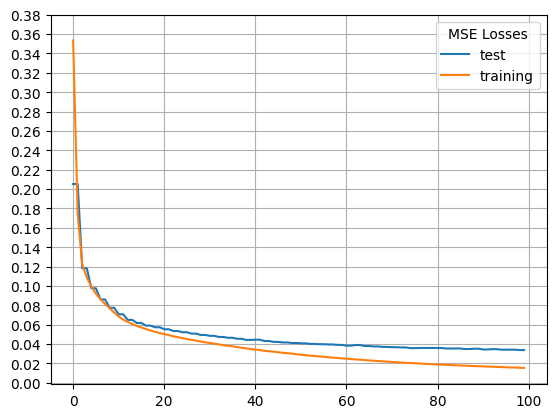

In [3]:
import matplotlib.pyplot as plt

# np.array(tlh[0]).mean(axis=1)#, trlh.mean(axis=1)
# tlh[0]#.mean(axis=1)

plt.plot(np.array(tlh[0]).mean(axis=1).repeat(logging_steps), label="test")
plt.plot(np.array(trlh[0]).mean(axis=1), label="training")

plt.legend(title="MSE Losses")

plt.yticks(np.arange(0, .4, .02))

plt.grid()
plt.show()

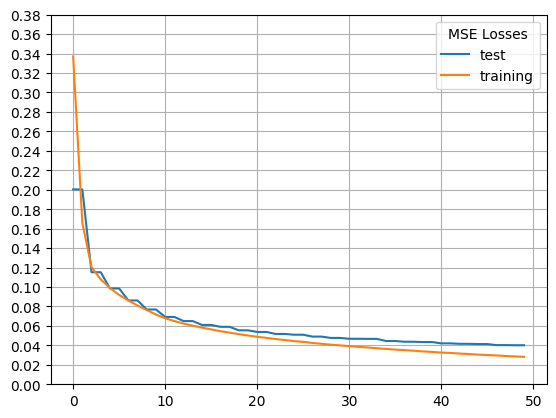

In [29]:
import matplotlib.pyplot as plt

# np.array(tlh[0]).mean(axis=1)#, trlh.mean(axis=1)
# tlh[0]#.mean(axis=1)

plt.plot(np.array(tlh[0]).mean(axis=1).repeat(logging_steps), label="test")
plt.plot(np.array(trlh[0]).mean(axis=1), label="training")

plt.legend(title="MSE Losses")

plt.yticks(np.arange(0, .4, .02))

plt.grid()
plt.show()

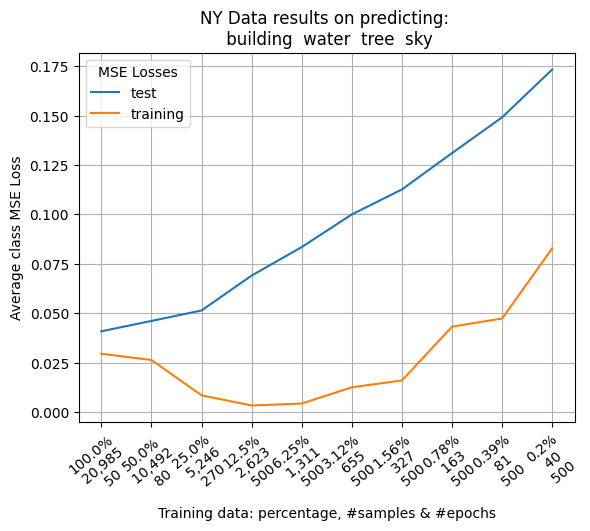

In [13]:
import matplotlib.pyplot as plt
plt.plot([np.mean(t[-1]) for t in tlh], label="test")
plt.plot([np.mean(t[-1]) for t in trlh], label="training")
xtick_labels = (100*training_set_percentages).round(2)#[:-1]

xtick_labels = [f"{xl}%\n {int(tp):,}\n {nept:,}" for (xl, tp), nept in zip(zip(xtick_labels, training_set_percentages * len(visibility_dataset_df) *.8), num_epochs_per_tsp)]

plt.xticks(np.arange(10), xtick_labels\
           , rotation=40)
plt.legend(title="MSE Losses")

plt.title(f"NY Data results on predicting: \n{' '.join(non_empty_classes_names)}")
plt.xlabel("Training data: percentage, #samples & #epochs")
plt.ylabel("Average class MSE Loss")
plt.grid()
plt.show()

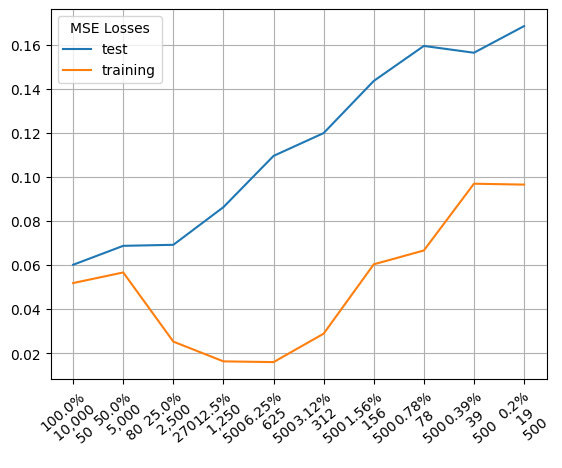

In [7]:
import matplotlib.pyplot as plt
plt.plot([np.mean(t[-1]) for t in tlh], label="test")
plt.plot([np.mean(t[-1]) for t in trlh], label="training")
xtick_labels = (100*training_set_percentages).round(2)#[:-1]

xtick_labels = [f"{xl}%\n {int(tp):,}\n {nept:,}" for (xl, tp), nept in zip(zip(xtick_labels, training_set_percentages * len(visibility_dataset_df) *.8), num_epochs_per_tsp)]

plt.xticks(np.arange(10), xtick_labels\
           , rotation=40)
plt.legend(title="MSE Losses")
plt.grid()
plt.show()

In [5]:
train_loader.dataset

In [7]:
train_loader.dataset.output

tensor([], size=(20985, 0))

In [6]:
train_loader.dataset.features_column_names

['xn', 'yn', 'zn', 'xhn', 'yhn', 'zhn']

In [8]:
visibility_dataset_df

,x,y,z,xh,yh,zh,f_xyz,image_name,xn,yn,zn,xhn,yhn,zhn,f_xyz_raw
0,592.664199,51.652981,104.634690,170.357425,4.103539,-179.303432,[],pos0-0-visibility-20,-0.510216,-0.006337,-0.59967,-43.95846,-2.050326,-44.112252,[]
1,592.664199,101.652981,104.634690,172.557271,4.127195,-179.461323,[],pos0-0-visibility-70,-0.510216,0.025007,-0.59967,-43.880233,-2.049485,-44.117867,[]
2,592.664199,51.652981,104.634690,-179.925623,4.162137,179.994602,[],pos0-1-visibility-20,-0.510216,-0.006337,-0.59967,-56.414469,-2.048242,-31.335671,[]
3,592.664199,101.652981,104.634690,-177.677119,4.158732,179.831453,[],pos0-1-visibility-70,-0.510216,0.025007,-0.59967,-56.334513,-2.048363,-31.341473,[]
4,592.664199,51.652981,104.634690,179.685299,-12.968808,179.929374,[],pos0-2-visibility-20,-0.510216,-0.006337,-0.59967,-43.626762,-2.657416,-31.337991,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26227,650.916803,89.437580,1729.655697,6.212651,-4.593465,0.499488,[],pos2185-3-visibility-70,-0.473697,0.01735,0.41905,-49.795422,-2.35959,-37.718489,[]
26228,650.916803,39.437580,1729.655697,4.707461,19.569814,-1.579946,[],pos2185-4-visibility-20,-0.473697,-0.013995,0.41905,-49.848946,-1.500348,-37.792433,[]
26229,650.916803,89.437580,1729.655697,2.582658,19.612578,-0.867412,[],pos2185-4-visibility-70,-0.473697,0.01735,0.41905,-49.924504,-1.498827,-37.767096,[]
26230,650.916803,39.437580,1729.655697,0.450726,19.630435,-0.151425,[],pos2185-5-visibility-20,-0.473697,-0.013995,0.41905,-50.000315,-1.498192,-37.741635,[]


In [ ]:
np.vstack([eval(vd) if type(vd) == str else vd for vd in vis_df[label_column_name]]).astype(np.float32)

In [8]:
encoder_net

NeRF(
  (fc_in): Linear(in_features=60, out_features=256, bias=True)
  (fc_1): Linear(in_features=256, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=256, bias=True)
  (fc_3): Linear(in_features=256, out_features=256, bias=True)
  (fc_4): Linear(in_features=256, out_features=256, bias=True)
  (fc_5): Linear(in_features=316, out_features=256, bias=True)
  (fc_6): Linear(in_features=256, out_features=256, bias=True)
  (fc_7): Linear(in_features=256, out_features=256, bias=True)
  (fc_8): Linear(in_features=256, out_features=257, bias=True)
  (fc_9): Linear(in_features=316, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=4, bias=True)
  (relu_actvn): ReLU()
  (sigmoid_actvn): Tanh()
)

In [5]:
[np.mean(t[-1]) for t in tlh]

[0.06020590215893462,
 0.06879414836149664,
 0.06925956438090652,
 0.08634899629922584,
 0.10958782163448633,
 0.11994087203145026,
 0.1435880891266279,
 0.1594778989173472,
 0.15638964773602784,
 0.16846963239833712]

# Training Density experiments

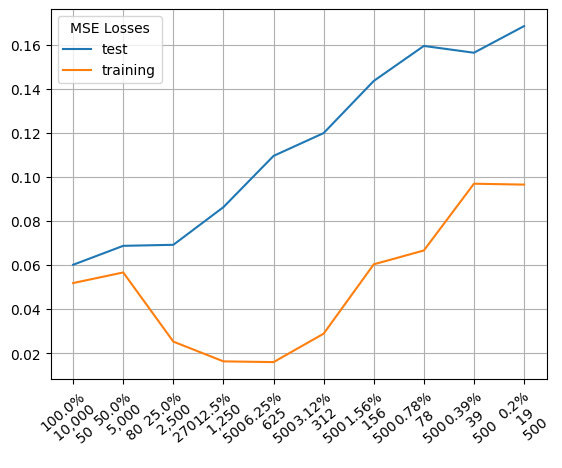

In [7]:
import matplotlib.pyplot as plt
plt.plot([np.mean(t[-1]) for t in tlh], label="test")
plt.plot([np.mean(t[-1]) for t in trlh], label="training")
xtick_labels = (100*training_set_percentages).round(2)#[:-1]

xtick_labels = [f"{xl}%\n {int(tp):,}\n {nept:,}" for (xl, tp), nept in zip(zip(xtick_labels, training_set_percentages * 10000), num_epochs_per_tsp)]

plt.xticks(np.arange(10), xtick_labels\
           , rotation=40)
plt.legend(title="MSE Losses")
plt.grid()
plt.show()

# To much fine tunining for small sizes

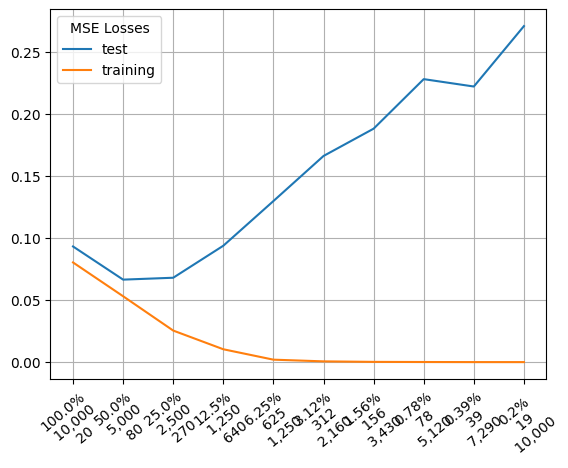

In [10]:
import matplotlib.pyplot as plt
plt.plot([np.mean(t[-1]) for t in tlh], label="test")
plt.plot([np.mean(t[-1]) for t in trlh], label="training")
xtick_labels = (100*training_set_percentages).round(2)#[:-1]

xtick_labels = [f"{xl}%\n {int(tp):,}\n {nept:,}" for (xl, tp), nept in zip(zip(xtick_labels, training_set_percentages * 10000), num_epochs_per_tsp)]

plt.xticks(np.arange(10), xtick_labels\
           , rotation=40)
plt.legend(title="MSE Losses")
plt.grid()
plt.show()

# Not enough finetuning for large splits:

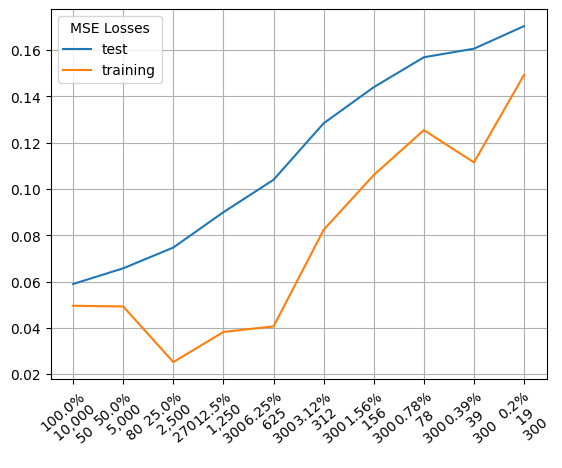

In [2]:
import matplotlib.pyplot as plt
plt.plot([np.mean(t[-1]) for t in tlh], label="test")
plt.plot([np.mean(t[-1]) for t in trlh], label="training")
xtick_labels = (100*training_set_percentages).round(2)#[:-1]

xtick_labels = [f"{xl}%\n {int(tp):,}\n {nept:,}" for (xl, tp), nept in zip(zip(xtick_labels, training_set_percentages * 10000), num_epochs_per_tsp)]

plt.xticks(np.arange(10), xtick_labels\
           , rotation=40)
plt.legend(title="MSE Losses")
plt.grid()
plt.show()

# Keep same number of epochs

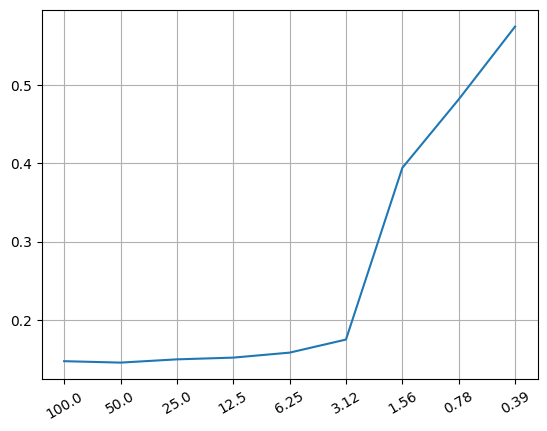

In [31]:
import matplotlib.pyplot as plt
plt.plot([np.mean(t[-1]) for t in tlh[1:]])
xtick_labels = (100*training_set_percentages).round(2)[:-1]

xtick_labels = [f"{xl}" for xl, tp in zip(xtick_labels, training_set_percentages * 10000)]

plt.xticks(np.arange(9), xtick_labels\
           , rotation=30)
plt.grid()
plt.show()

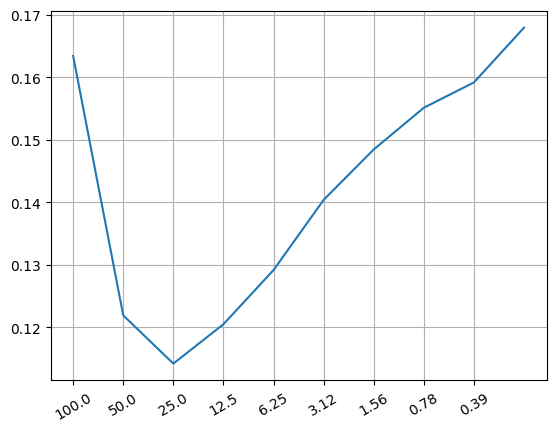

In [6]:
import matplotlib.pyplot as plt
plt.plot([np.mean(t[-1]) for t in tlh])
xtick_labels = (100*training_set_percentages).round(2)#cv[:-1]

xtick_labels = [f"{xl}" for xl, tp in zip(xtick_labels, training_set_percentages * 10000)]

plt.xticks(np.arange(9), xtick_labels\
           , rotation=30)
plt.grid()
plt.show()

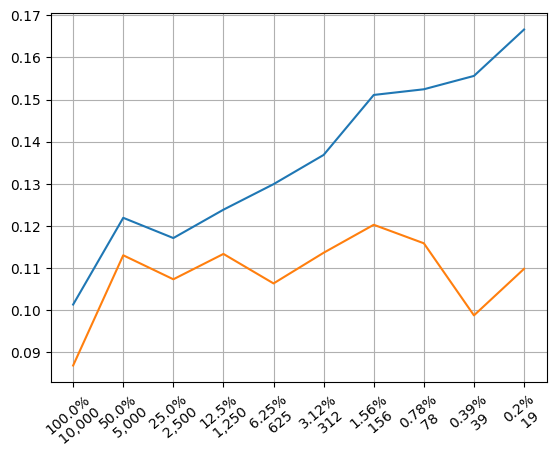

In [14]:
import matplotlib.pyplot as plt
plt.plot([np.mean(t[-1]) for t in tlh], label="test")
plt.plot([np.mean(t[-1]) for t in trlh], label="training")
xtick_labels = (100*training_set_percentages).round(2)#[:-1]

xtick_labels = [f"{xl}%\n {int(tp):,}" for xl, tp in zip(xtick_labels, training_set_percentages * 10000)]

plt.xticks(np.arange(10), xtick_labels\
           , rotation=40)
plt.grid()
plt.show()

In [12]:
[np.mean(t[-1]) for t in tlh[1:]]

[0.1474463864453137,
 0.14563228766024114,
 0.14978062681518495,
 0.15198999545648695,
 0.1583545425374061,
 0.17502825907170771,
 0.39414195842742916,
 0.4815123521000147,
 0.5744139055669308]

In [21]:
(100*training_set_percentages).round(2)[:-1]

array([100.  ,  50.  ,  25.  ,  12.5 ,   6.25,   3.12,   1.56,   0.78,
         0.39])

In [27]:
training_set_percentages * 10000

array([10000.     ,  5000.     ,  2500.     ,  1250.     ,   625.     ,
         312.5    ,   156.25   ,    78.125  ,    39.0625 ,    19.53125])

In [2]:
np.array(tlh)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

# Based on the code developed in `1_encoder_location`

In [1]:
from scripts.architectures.train_location_encoder \
import get_location_visibility_encoder, process_locations_visibility_data_frame\
, get_location_visibility_loaders, run_one_epoch_location_encoder

from scripts.helper_ply_SensatUrban_0 import ins_dict
import numpy as np

#zooms prediction data frame approach, 25000:
# file_store = "./data/cambridge_block_8_fragment_25000_5_zooms-03-015-005_encoder_locations_v2.csv"
#semantics prediction data frame approach, 12500:
file_store = "./data/cambridge_block_8_fragment_semantic_locs-2500_dirs-5_visual/locations.csv"

#1. Read locations.csv and process data frame with normalized coordinate inputs and labels
visibility_dataset_df, nec = process_locations_visibility_data_frame(file_store, min_percentage_per_class=.05)
non_empty_classes_names                  = np.array(list(ins_dict.values())+["empty"])[nec]
print(f"Found classes {non_empty_classes_names}")

#2. setup `torch` dataset and loaders
train_loader, test_loader = get_location_visibility_loaders(processed_vis_loc_df=visibility_dataset_df\
, train_set_percentage=1, test_size=0.2, batch_size=32, pos_enc_dim=10)

#3. Setup NeRF-like location encoder:
enc_input_size, num_present_classes          = train_loader.dataset.input_dir.shape[1], train_loader.dataset.output.shape[1]
encoder_net, criterion, optimizer, scheduler =  get_location_visibility_encoder(enc_input_size, num_present_classes)


encoder_net


Found classes ['ground' 'tree' 'building' 'empty']


NeRF(
  (fc_in): Linear(in_features=60, out_features=256, bias=True)
  (fc_1): Linear(in_features=256, out_features=256, bias=True)
  (fc_2): Linear(in_features=256, out_features=256, bias=True)
  (fc_3): Linear(in_features=256, out_features=256, bias=True)
  (fc_4): Linear(in_features=256, out_features=256, bias=True)
  (fc_5): Linear(in_features=316, out_features=256, bias=True)
  (fc_6): Linear(in_features=256, out_features=256, bias=True)
  (fc_7): Linear(in_features=256, out_features=256, bias=True)
  (fc_8): Linear(in_features=256, out_features=257, bias=True)
  (fc_9): Linear(in_features=316, out_features=128, bias=True)
  (fc_out): Linear(in_features=128, out_features=4, bias=True)
  (relu_actvn): ReLU()
  (sigmoid_actvn): Tanh()
)

# Training Loop

In [2]:
from tqdm.notebook import tqdm

num_epochs          = 30
training_progress   = tqdm(range(num_epochs))
logging_steps       = 5
tr_losses_history   = []
test_losses_history = []
test_loss           = np.ones(1)
for epoch in training_progress:
    
    tr_loss = run_one_epoch_location_encoder(encoder_net, criterion, optimizer\
                                   , train_loader, training_epoch=True)
    tr_losses_history.append(tr_loss)    
    training_progress.set_description(f'Epoch {epoch +1} / {num_epochs}'+
          f'- Training loss {tr_loss.mean()**.5:.5f} - test loss {test_loss.mean()**.5:.5f}'  )

    if epoch % logging_steps == 0:
        
        test_loss = 0
        test_loss = run_one_epoch_location_encoder(encoder_net, criterion, optimizer\
                                   , test_loader, training_epoch=False)

        #test_loss = test_loss #/ len(test_loader)
        test_losses_history.append(test_loss)

  0%|          | 0/30 [00:00<?, ?it/s]

In [9]:
np.vstack(tr_losses_history).mean(axis=1)

array([0.49225527, 0.09650741, 0.09443307, 0.09278004, 0.09099416,
       0.08870262, 0.08541514, 0.08073829, 0.07633817, 0.07408223,
       0.07246723, 0.07099816, 0.06944656, 0.06782584, 0.06591341,
       0.06388065, 0.06161788, 0.05942434, 0.05756065, 0.05598709,
       0.05481482, 0.05365449, 0.05263008, 0.05173069, 0.05101748,
       0.05020926, 0.04945164, 0.0487363 , 0.04788149, 0.04721128])

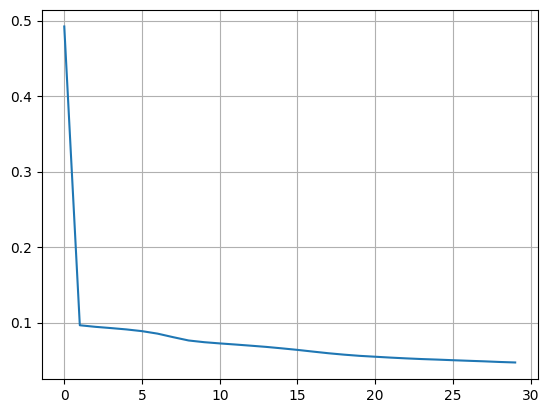

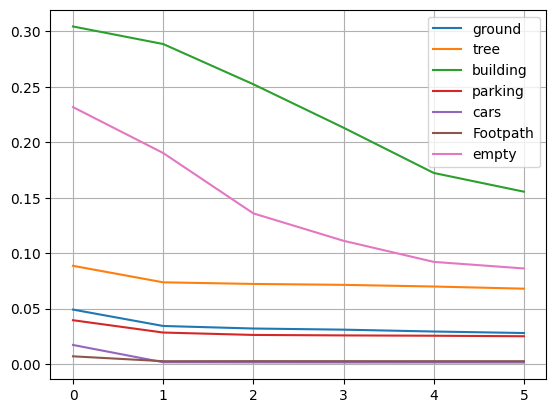

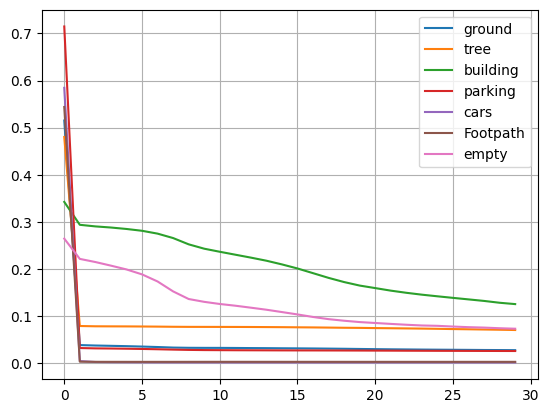

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.lineplot(np.vstack(tr_losses_history).mean(axis=1))

plt.grid()
plt.show()

for i in range(nec.sum()):
    sns.lineplot(np.vstack(test_losses_history)[:,i], label=non_empty_classes_names[i])

plt.grid()
plt.show()

for i in range(nec.sum()):
    sns.lineplot(np.vstack(tr_losses_history)[:,i], label=non_empty_classes_names[i])

plt.grid()
plt.show()

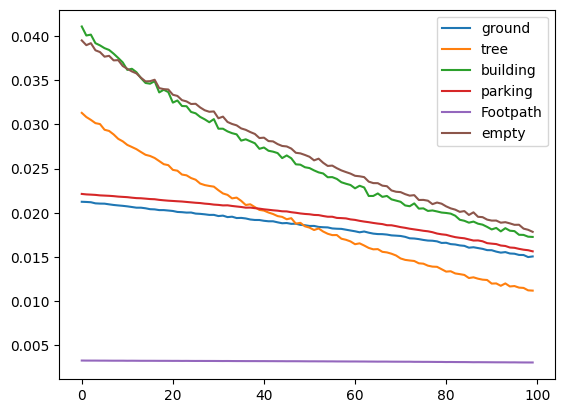

In [20]:
import seaborn as sns

non_empty_classes_names                  = np.array(list(ins_dict.values())+["empty"])[non_empty_classes]

for i in range(non_empty_classes.sum()):
    sns.lineplot(np.vstack(tr_losses_history)[:,i], label=non_empty_classes_names[i])



In [3]:
tr_losses_history

[array([0.55723421, 0.69419285, 0.29551908, 0.56009906, 0.6990181 ,
        0.25837669]),
 array([0.03684028, 0.08023841, 0.28580904, 0.03231677, 0.00818098,
        0.2204395 ]),
 array([0.03619746, 0.07949235, 0.28312942, 0.03174433, 0.00441421,
        0.2125834 ]),
 array([0.03590925, 0.07899288, 0.28094516, 0.03176783, 0.00387315,
        0.20527887]),
 array([0.03556295, 0.07855412, 0.27832106, 0.03171257, 0.003665  ,
        0.19593041]),
 array([0.03516645, 0.07814898, 0.27477434, 0.03159989, 0.00352576,
        0.18255607]),
 array([0.03445471, 0.07766887, 0.26907541, 0.0312932 , 0.00344399,
        0.16436654]),
 array([0.0334127 , 0.07709581, 0.25971624, 0.03069628, 0.00339164,
        0.14542361]),
 array([0.03241538, 0.07639098, 0.24985424, 0.02992888, 0.00338594,
        0.13571748]),
 array([0.0319243 , 0.07564972, 0.24294969, 0.02940391, 0.00340396,
        0.13137255]),
 array([0.03161653, 0.07509992, 0.23776864, 0.02903162, 0.0034327 ,
        0.1285519 ]),
 array([0.

In [3]:
tr_losses_history

[array([0.55723421, 0.69419285, 0.29551908, 0.56009906, 0.6990181 ,
        0.25837669]),
 array([0.03684028, 0.08023841, 0.28580904, 0.03231677, 0.00818098,
        0.2204395 ]),
 array([0.03619746, 0.07949235, 0.28312942, 0.03174433, 0.00441421,
        0.2125834 ]),
 array([0.03590925, 0.07899288, 0.28094516, 0.03176783, 0.00387315,
        0.20527887]),
 array([0.03556295, 0.07855412, 0.27832106, 0.03171257, 0.003665  ,
        0.19593041]),
 array([0.03516645, 0.07814898, 0.27477434, 0.03159989, 0.00352576,
        0.18255607]),
 array([0.03445471, 0.07766887, 0.26907541, 0.0312932 , 0.00344399,
        0.16436654]),
 array([0.0334127 , 0.07709581, 0.25971624, 0.03069628, 0.00339164,
        0.14542361]),
 array([0.03241538, 0.07639098, 0.24985424, 0.02992888, 0.00338594,
        0.13571748]),
 array([0.0319243 , 0.07564972, 0.24294969, 0.02940391, 0.00340396,
        0.13137255]),
 array([0.03161653, 0.07509992, 0.23776864, 0.02903162, 0.0034327 ,
        0.1285519 ]),
 array([0.

In [9]:
tr_losses_history[0]**.5

array([0.74648122, 0.83318236, 0.54361666, 0.74839766, 0.83607303,
       0.50830767])

In [6]:
tr_losses_history[-1]**.5

array([0.1458412 , 0.17769798, 0.20295695, 0.148952  , 0.05703223,
       0.19932165])

In [8]:
test_loss**.5#.round(4)

array([0.14561683, 0.19260339, 0.27705925, 0.14806875, 0.0504431 ,
       0.2429595 ])

In [29]:
test_losses_history

[array([4.34093597e-04, 9.27420981e-04, 2.96060527e-03, 3.68322512e-04,
        4.03118076e-05, 1.60363710e-03])]

# Method for inspecting the accuracy of the predictions:

In [14]:
import numpy as np
np.array(list(ins_dict.values())+["empty"])[non_empty_classes]

array(['ground', 'tree', 'building', 'parking', 'Footpath', 'empty'],
      dtype='<U17')

In [22]:
encoder_net(test_loader.dataset[:1]["input_pos"], test_loader.dataset[:1]["input_dir"]),\
test_loader.dataset[:1]["output"]

(tensor([[-0.9584, -0.9276, -0.3894, -0.9745, -0.9968,  0.3743]],
        grad_fn=<TanhBackward0>),
 tensor([[-0.9972, -1.0000, -0.6855, -0.9995, -1.0000,  0.6821]]))

In [18]:
encoder_net(train_loader.dataset[:1]["input_pos"], train_loader.dataset[:1]["input_dir"]),\
train_loader.dataset[:1]["output"]



(tensor([[ 0.0168,  0.0469, -0.1351,  0.1936,  0.1242,  0.0269]],
        grad_fn=<TanhBackward0>),
 tensor([[-0.9767, -0.8144, -0.7103, -0.9834, -0.9931,  0.4543]]))

In [6]:
tr_losses_history

[array([0.57944652, 0.58106477, 0.29953047, 0.58580056, 0.5155959 ,
        0.24646906]),
 array([0.03618482, 0.08079771, 0.28637237, 0.03135134, 0.00392729,
        0.20499103]),
 array([0.03547963, 0.07991858, 0.28271844, 0.03071233, 0.00340888,
        0.1975515 ]),
 array([0.03519878, 0.07923332, 0.2788611 , 0.03052986, 0.00325862,
        0.18930926]),
 array([0.03485245, 0.07857961, 0.27439427, 0.03034869, 0.00318015,
        0.18045868])]

In [5]:
test_losses_history

[array([5.54385394e-04, 9.71237190e-04, 3.71779281e-03, 4.70325169e-04,
        8.40877481e-05, 2.59935975e-03])]

# Drafts:

In [6]:
output,labels

(tensor([[-0.7428, -0.7699, -0.2657, -0.7985, -0.9150, -0.3034],
         [-0.7792, -0.8039, -0.1640, -0.7898, -0.9311, -0.2958],
         [-0.7727, -0.7682, -0.2385, -0.7863, -0.8636, -0.3099],
         [-0.8097, -0.8230, -0.2963, -0.8282, -0.9429, -0.3183]],
        grad_fn=<TanhBackward0>),
 tensor([[-0.6108, -0.9916,  0.4460, -1.0000, -0.9693, -0.8779],
         [-0.9191, -0.9977,  0.1951, -1.0000, -1.0000, -0.2783],
         [-0.9846, -0.8970, -0.4901, -0.9907, -1.0000,  0.3613],
         [-0.7501, -1.0000,  0.3763, -0.9999, -0.7646, -0.8618]]))

In [13]:
import torch
torch.nn.MSELoss(size_average=None, reduce=None, reduction='none')(output,labels)

tensor([[1.7441e-02, 4.9158e-02, 5.0650e-01, 4.0604e-02, 2.9449e-03, 3.3007e-01],
        [1.9584e-02, 3.7534e-02, 1.2896e-01, 4.4189e-02, 4.7532e-03, 3.0414e-04],
        [4.4882e-02, 1.6590e-02, 6.3273e-02, 4.1758e-02, 1.8612e-02, 4.5045e-01],
        [3.5530e-03, 3.1333e-02, 4.5237e-01, 2.9457e-02, 3.1798e-02, 2.9535e-01]],
       grad_fn=<MseLossBackward0>)

In [23]:

torch.nn.MSELoss(size_average=None, reduce=None)(output,labels).sum(axis=0)


torch.nn.MSELoss(reduce=None)(output,labels).sum(axis=0)


tensor([0.0855, 0.1346, 1.1511, 0.1560, 0.0581, 1.0762],
       grad_fn=<SumBackward1>)

In [34]:
torch.nn.MSELoss(reduction='none')(output,labels)#.sum(axis=0)

tensor([[1.7441e-02, 4.9158e-02, 5.0650e-01, 4.0604e-02, 2.9449e-03, 3.3007e-01],
        [1.9584e-02, 3.7534e-02, 1.2896e-01, 4.4189e-02, 4.7532e-03, 3.0414e-04],
        [4.4882e-02, 1.6590e-02, 6.3273e-02, 4.1758e-02, 1.8612e-02, 4.5045e-01],
        [3.5530e-03, 3.1333e-02, 4.5237e-01, 2.9457e-02, 3.1798e-02, 2.9535e-01]],
       grad_fn=<MseLossBackward0>)

In [24]:

for l in torch.nn.MSELoss(size_average=None, reduce=None, reduction='none')(output,labels).sum(axis=0):
    l.backwards()

AttributeError: 'Tensor' object has no attribute 'backwards'

In [22]:
torch.nn.MSELoss(size_average=None, reduce=None, reduction='none')(output\
                                           ,labels).sum(axis=0).sum().backward()

In [7]:
criterion(output,labels)

tensor([[0.2208, 0.0732, 0.1606, 0.0520, 0.0019, 0.2265],
        [0.0071, 0.0101, 0.2279, 0.0018, 0.0022, 0.0058],
        [0.0080, 0.0123, 0.0309, 0.4252, 0.0037, 0.1683],
        [0.0164, 0.0041, 0.0060, 0.0054, 0.0047, 0.0847]],
       grad_fn=<MseLossBackward0>)

In [10]:
input_pos.shape

torch.Size([4, 60])

In [13]:
criterion(output,labels).sum(axis=0).detach().numpy()

array([0.25224692, 0.09972337, 0.42548472, 0.48437396, 0.01251603,
       0.48529923], dtype=float32)

In [19]:
criterion(output,labels).sum(axis=0), criterion(output,labels).mean()

(tensor([0.2522, 0.0997, 0.4255, 0.4844, 0.0125, 0.4853],
        grad_fn=<SumBackward1>),
 tensor(0.0733, grad_fn=<MeanBackward0>))

In [18]:
len(train_loader), len(train_loader.dataset)

(313, 10000)

In [16]:
encoder_net.fc_out.out_features

6

In [5]:
# lr_start = 5*1e-4
# lr_end   = 5*1e-6
# num_epochs = 1000
num_epochs = 1
# #weight_decay = 
# weight_decay = (lr_end - lr_start) / num_epochs
training_progress = tqdm(range(num_epochs))
logging_steps = 30
tr_losses_history   = []#[1]
test_losses_history = []#[1]
# num_epochs = 1000
test_loss = 1
for epoch in tqdm(range(num_epochs)):
    current_loss = 0.0
    for i, sample_batch in enumerate(train_loader):
        #inputs, labels  = sample_batch
        #input_pos, input_dir, labels  = sample_batch
        input_pos = sample_batch["input_pos"]
        input_dir = sample_batch["input_dir"]
        labels    = sample_batch["output"]
        
        output = encoder_net(input_pos, input_dir)
        optimizer.zero_grad()
        #loss = criterion(output,labels)
        
        loss = criterion(output,labels).sum()
        # loss = -(labels * torch.log(output)+ (1-labels) * torch.log(1-output)).mean()
        loss.backward()
        optimizer.step()
        #output = (output>0.5).float()
        #correct = (output == labels).float().sum()
        #print("Epoch {}/{}, loss:{:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs,loss.item(),correct/output.shape[0]))
        current_loss += loss.item()
        
        #if i % logging_steps == 0:
#             losses_history.append(current_loss / logging_steps)
#             training_progress.set_description(f'Epoch {epoch +1} / {num_epochs} - Loss after mini-batch %5d: %.3f' % (i + 1, current_loss / logging_steps))

    tr_loss = (current_loss / len(train_loader))
    tr_losses_history.append(tr_loss)    
    training_progress.set_description(f'Epoch {epoch +1} / {num_epochs} - Training loss {tr_loss:.5f} - test loss {test_loss:.5f}'  )

    #########################################################
    ############### Test Loop: ##################################
    #########################################################
    if epoch % logging_steps == 0:
        
        test_loss = 0
        for i, sample_batch in enumerate(test_loader):
            #inputs, labels  = sample_batch
#             input_pos, input_dir, labels  = sample_batch
            input_pos = sample_batch["input_pos"]
            input_dir = sample_batch["input_dir"]
            labels    = sample_batch["output"]

            output = encoder_net(input_pos, input_dir)
            #optimizer.zero_grad()
            #loss = criterion(output,labels)
            loss = criterion(output,labels).sum()
            # loss = -(labels * torch.log(output)+ (1-labels) * torch.log(1-output)).mean()
            #loss.backward()
            #optimizer.step()
            #output = (output>0.5).float()
            #correct = (output == labels).float().sum()
            #print("Epoch {}/{}, loss:{:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs,loss.item(),correct/output.shape[0]))
            test_loss += loss.item()
            
        test_loss = test_loss / len(test_loader)
        test_losses_history.append(test_loss)

#             print('Loss after mini-batch %5d: %.3f' %
#                 (i + 1, current_loss / 500))
    #scheduler.step()
    current_loss = 0.0

    

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
criterion(output,labels).sum()

tensor(25.0471, grad_fn=<SumBackward0>)

In [5]:
encoder_net(input_pos, input_dir)

tensor([[-0.8976, -0.8773, -0.2698, -0.9156, -0.9643, -0.0162],
        [-0.8792, -0.8913,  0.0053, -0.9363, -0.9763, -0.2274],
        [-0.8507, -0.8262, -0.1055, -0.8513, -0.9590, -0.3099],
        [-0.8652, -0.8660, -0.2111, -0.9156, -0.9638, -0.1546],
        [-0.8715, -0.8068, -0.2510, -0.9188, -0.9570, -0.1225],
        [-0.8922, -0.9100, -0.2978, -0.9483, -0.9717, -0.0114],
        [-0.9199, -0.8937, -0.0838, -0.9268, -0.9702, -0.2582],
        [-0.8439, -0.8736, -0.2697, -0.8936, -0.9596, -0.1534],
        [-0.9083, -0.8612, -0.0699, -0.9097, -0.9657, -0.2018],
        [-0.8521, -0.8265, -0.2905, -0.9186, -0.9387, -0.1573],
        [-0.8861, -0.8781, -0.0760, -0.9161, -0.9719, -0.2372],
        [-0.8720, -0.8508, -0.1363, -0.8880, -0.9626, -0.2601],
        [-0.8563, -0.8677, -0.3233, -0.9121, -0.9602, -0.1685],
        [-0.9276, -0.9049, -0.0934, -0.9489, -0.9804, -0.1885],
        [-0.9009, -0.8663, -0.1176, -0.8971, -0.9650, -0.3326],
        [-0.8558, -0.8374, -0.1143, -0.9

In [4]:
tr_losses_history, test_losses_history

([0.4347983839603278,
  0.11043536439299964,
  0.1069511069109836,
  0.10395032005569044,
  0.09989410653091467],
 [0.12045348190431353])

In [4]:
tr_losses_history, test_losses_history

([0.5039529129624748, 0.10883043952786123], [0.13023661039298093])

In [15]:
tr_losses_history, test_losses_history

([0.11177817945139476, 0.10844489822562892], [0.1080398044631451])

# Modify v1 dataframe:

In [23]:
import pandas as pd
intermediate_df = pd.read_csv( "./data/cambridge_block_8_fragment_25000_5_zooms-03-015-005_encoder_locations.csv")

intermediate_df["f_xyz_original"] = intermediate_df["f_xyz"]
intermediate_df["f_xyz"]          = intermediate_df["f_xyz_original"].apply(lambda d: d.replace(" 2073600", "").replace(",", ""))

intermediate_df.to_csv("./data/cambridge_block_8_fragment_25000_5_zooms-03-015-005_encoder_locations_v2.csv", index=False)
# intermediate_df

# Developed methods, moved to

`architectures.train_location_encoder.py`

In [ ]:
def run_one_epoch_location_encoder(encoder_net, criterion, optimizer, data_loader, training_epoch=True):
    
    #sum of losses for each sample to be normalized by len(dataset)
    current_losses = np.zeros(encoder_net.fc_out.out_features)
    
    for i, sample_batch in enumerate(data_loader):
        
        input_pos = sample_batch["input_pos"]
        input_dir = sample_batch["input_dir"]
        labels    = sample_batch["output"]
        
        output = encoder_net(input_pos, input_dir)
        optimizer.zero_grad()
        loss = criterion(output,labels)
        
        if training_epoch:
            loss.mean().backward()
            optimizer.step()
        
        #
        current_losses += loss.sum(axis=0).detach().numpy() 
    
    mean_epoch_loss = (current_losses / len(data_loader.dataset))
    return mean_epoch_loss#, current_losses
    #tr_loss = (current_losses / len(train_loader))
#     tr_losses_history.append(tr_loss)    
#     training_progress.set_description(f'Epoch {epoch +1} / {num_epochs} - Training loss {tr_loss:.5f} - test loss {test_loss:.5f}'  )

#run_one_epoch_location_encoder(encoder_net, criterion, optimizer\
#                                 , train_loader, training_epoch=True)
run_one_epoch_location_encoder(encoder_net, criterion, optimizer\
                               , test_loader, training_epoch=False)

def get_location_visibility_encoder(enc_input_size, num_present_classes):
    '''
    Setup training model: 
        enc_input_size: stands for both the size of the location and of the direction.
        num_present_classes: size of the output layer.
    returns: encoder_net, criterion, optimizer, scheduler
    '''
    #Hyperparameters:
    pos_enc_dim         = 10 # 4 #See nerf 5.1 Positional encoding, page 8 - L = 4 or L=10 for γ(d).
    xyz_dim             = 6  # 6 - x,y,z,xh,yh,zh
    lr_start            = 1e-5#5*1e-5
    
    #Model and loss declaration
    
    encoder_net = network.nerf.NeRF(pos_dim=enc_input_size, output_dim=num_present_classes, view_dir_dim=enc_input_size) 
    criterion   = torch.nn.MSELoss()
    optimizer   = torch.optim.Adam(encoder_net.parameters(), lr=lr_start, eps=1e-8)#,weight_decay=
    scheduler   = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

    return encoder_net, criterion, optimizer, scheduler

def get_location_visibility_encoder(enc_input_size, num_present_classes):
    '''
    Setup training model: 
        enc_input_size: stands for both the size of the location and of the direction.
        num_present_classes: size of the output layer.
    returns: encoder_net, criterion, optimizer, scheduler
    '''
    #Hyperparameters:
    pos_enc_dim         = 10   # 4 or 10 #See NeRF paper section 5.1 Positional encoding, page 8 - L = 4 or L=10 for γ(d).
    xyz_dim             = 6    # 6 - x,y,z,xh,yh,zh
    lr_start            = 1e-5 
    
    #Model and loss declaration
    
    encoder_net = network.nerf.NeRF(pos_dim=enc_input_size, output_dim=num_present_classes, view_dir_dim=enc_input_size) 
    criterion   = torch.nn.MSELoss()
    optimizer   = torch.optim.Adam(encoder_net.parameters(), lr=lr_start, eps=1e-8)#,weight_decay=
    scheduler   = StepLR(optimizer, step_size=100, gamma=0.1)

    return encoder_net, criterion, optimizer, scheduler



def get_location_visibility_loaders(processed_vis_loc_df, test_size=0.2, batch_size=32):
    """Return train and test loaders based on processed visibility data frame"""
    train_df, test_df     = train_test_split(processed_vis_loc_df, test_size=test_size)

    label_column_name     = "f_xyz"
    features_column_names = ["xn", "yn", "zn", "xhn", "yhn", "zhn"]
    
    training_dataset = network.nerf.EncoderNeRFDataset(train_df, label_column_name=label_column_name, features_column_names=features_column_names)
    testing_dataset  = network.nerf.EncoderNeRFDataset(test_df, label_column_name=label_column_name, features_column_names=features_column_names)

    train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True) # load data
    test_loader  = torch.utils.data.DataLoader(dataset=testing_dataset, batch_size=batch_size, shuffle=True) # load data

    return train_loader, test_loader


def process_locations_visibility_data_frame(file_store):
    '''
    Process locations.csv file from file_store. 
    Table expected columns:
        - x,y,z,xh,yh,zh,f_xyz
    Normalize coordinates and only consider non empty columns as labels.
    Returns:
    processed_data_frame and indexes of non empty labels
    '''
    
    visibility_dataset_df = pd.read_csv(file_store)#, index_col=0)
    
    #predicted_zooms = len(eval(visibility_dataset_df["f_xyz"].values[0])) - 1#.shape

    #Normalize xyz coordinates - substract mean and divide by max
    visibility_dataset_df[["xn", "yn", "zn"]] = visibility_dataset_df[["x", "y", "z"]] - np.mean(visibility_dataset_df.values[:,:3], axis=0)
    visibility_dataset_df[["xn", "yn", "zn"]] = visibility_dataset_df[["xn", "yn", "zn"]] / visibility_dataset_df[["xn", "yn", "zn"]].max().max()
    #Normalize xyz angles / view directions
    visibility_dataset_df[["xhn", "yhn", "zhn"]] = visibility_dataset_df[["xh", "yh", "zh"]] - np.mean(visibility_dataset_df.values[:,:3], axis=0)
    visibility_dataset_df[["xhn", "yhn", "zhn"]] = visibility_dataset_df[["xhn", "yhn", "zhn"]] / visibility_dataset_df[["xhn", "yhn", "zhn"]].max().max()


    #Read list column:
    visibility_dataset_df["f_xyz_raw"] = visibility_dataset_df["f_xyz"].apply(lambda d: [eval(d) for d in d.strip('[]').replace("\n", "").split(" ") if d.isdigit()])
    #Filter down to only labels that appear:
    max_per_row   = sum(visibility_dataset_df["f_xyz_raw"].iloc[0])
    non_empty_classes = np.sum(np.vstack((visibility_dataset_df["f_xyz_raw"].values)), axis=0) > (max_per_row * 100)
    visibility_dataset_df["f_xyz"] = visibility_dataset_df["f_xyz_raw"].apply(lambda d: \
                                      [p for (p, e) in zip(d, non_empty_classes) if e])
    #Normalize appearances:
    visibility_dataset_df["f_xyz"] = visibility_dataset_df["f_xyz"].apply(lambda d: [(2 * x) / max_per_row - 1 for x in d]) 
    
    return visibility_dataset_df, non_empty_classes

Found 4 classes appearing more than 5.0%: [' building' ' water' ' tree' ' sky']
Training data percentace 100.00% - 20,985 samples, for 300 epochs:


  0%|          | 0/300 [00:00<?, ?it/s]

Model saved at:
	./data/real_NY/models/encoder_300.pt


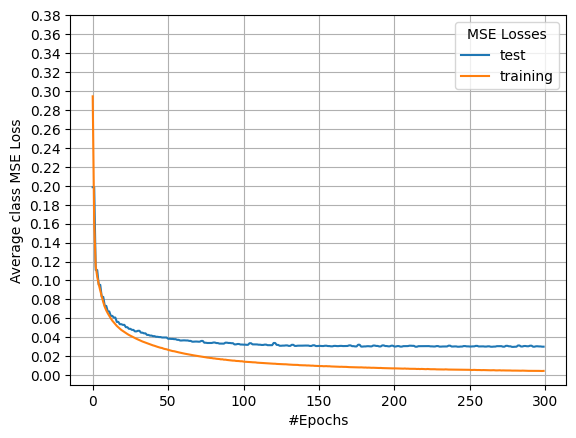

In [1]:
from scripts.architectures.train_location_encoder \
import get_location_visibility_encoder, process_locations_visibility_data_frame\
, get_location_visibility_loaders, run_one_epoch_location_encoder, train_model_on_data

import numpy as np
import os
import pandas as pd
import torch
import time

st = time.time()

from tqdm.notebook import tqdm
def train_model_on_data(data_path, num_epochs=200, tsp=1, mpc = .05):
    '''
    mpc: min_percentage_per_class - 0-1 how often a class should appear in the set to be considered.
    tsp: training set percentage  - out of the 80% of the data on how many samples should the model be trained
    '''

    NY_MESH = True
    # NY_MESH = False
    file_store = data_path + "/locations.csv"
    
    if NY_MESH:

        ins_dict = {c["color"] : c["class"] for c in  \
                pd.read_csv(f"{data_path}/classes_index.csv"\
                            , index_col=False).to_dict(orient="records")
                   }
        label_split=","
        classes_names = list(ins_dict.values())
    else:
        from scripts.helper_ply_SensatUrban_0 import ins_dict
        label_split=None
        file_store = "./data/cambridge_block_8_fragment_semantic_locs-2500_dirs-5_visual/locations.csv"
        classes_names = list(ins_dict.values())+["empty"]


    #1. Read locations.csv and process data frame with normalized coordinate inputs and labels
    visibility_dataset_df, nec = process_locations_visibility_data_frame(file_store\
                                             , min_percentage_per_class=mpc, label_split=label_split)
    non_empty_classes_names                  = np.array(classes_names)[nec]
    print(f"Found {nec.sum()} classes appearing more than {mpc*100:.1f}%: {non_empty_classes_names}")


    trlh = []
    tlh  = []

    #2. setup `torch` dataset and loaders
    pos_enc_dim = 10
    train_loader, test_loader = get_location_visibility_loaders(processed_vis_loc_df=visibility_dataset_df\
    , train_set_percentage=tsp, test_size=0.2, batch_size=32, pos_enc_dim=pos_enc_dim, seed=1)

    #3. Setup NeRF-like location encoder:
    enc_input_size, num_present_classes          = train_loader.dataset.input_dir.shape[1], train_loader.dataset.output.shape[1]
    encoder_net, criterion, optimizer, scheduler =  get_location_visibility_encoder(enc_input_size, num_present_classes)

    #4. Training loop
    print(f"Training data percentace {100 * tsp:.2f}% - {int(tsp * len(visibility_dataset_df)*.8):,} samples, for {num_epochs} epochs:")
    training_progress   = tqdm(range(num_epochs))
    logging_steps       = 2#5
    tr_losses_history   = []
    test_losses_history = []
    for epoch in training_progress:

        tr_loss = run_one_epoch_location_encoder(encoder_net, criterion, optimizer\
                                       , train_loader, training_epoch=True)
        tr_losses_history.append(tr_loss)    

        if epoch % logging_steps == 0:

            test_loss = run_one_epoch_location_encoder(encoder_net, criterion, optimizer\
                                       , test_loader, training_epoch=False)
            test_losses_history.append(test_loss)

        training_progress.set_description(f'Epoch {epoch +1} / {num_epochs}'+
              f'- Training loss {tr_loss.mean()**.5:.5f} - test loss {test_loss.mean()**.5:.5f}'  )

    trlh.append(tr_losses_history)
    tlh.append(test_losses_history)

    #save trained model:
    #0. create storage folder 
    models_path = data_path + "/models"
    if not os.path.exists(models_path):
        os.makedirs(models_path)
        print(f"Created data storage at:\n\t{models_path}")

    model_name = f"encoder_{num_epochs}.pt"
    trlh, tlh = np.vstack(trlh), np.vstack(tlh)
    pd.DataFrame({"classes_names":[classes_names]\
                  , "mpc":mpc\
                  , "non_empty_classes_names":[non_empty_classes_names]\
                  , "train_size": len(train_loader.dataset)
                  , "test_size": len(test_loader.dataset)
                  , "num_epochs":num_epochs\
                  , "pos_enc_dim" : pos_enc_dim
                  , "tsp":tsp\
                  , "enc_input_size":enc_input_size\
                  , "num_present_classes":num_present_classes\
                  , "tr_losses_history":[trlh]\
                  , "test_losses_history":[tlh]}).T\
    .to_csv(f"{models_path}/training_info_{num_epochs}.csv")
    

    # Save
    #torch.save(encoder_net.state_dict(), f"{models_path}/{model_name}")
    torch.save(encoder_net, f"{models_path}/{model_name}")

    print(f"Model saved at:\n\t{models_path}/{model_name}")
    
    return encoder_net, trlh, tlh#, test_loader



file_store = "./data/real_NY"
encoder_net, tr_losses_history, test_losses_history = train_model_on_data(data_path=file_store, num_epochs=300, tsp=1)


et = time.time()

print(f"Training for \n\t{1} epochs took \n\t{st-et:.1f}s, for an average of \n\t{st-et:.1f}s per epoch.")


import matplotlib.pyplot as plt

# np.array(tlh[0]).mean(axis=1)#, trlh.mean(axis=1)
# tlh[0]#.mean(axis=1)

plt.plot(np.array(test_losses_history).mean(axis=1).repeat(2), label="test")
plt.plot(np.array(tr_losses_history).mean(axis=1), label="training")

plt.legend(title="MSE Losses")

# plt.title(f"NY Data results on predicting: \n{' '.join(non_empty_classes_names)}")
plt.ylabel("Average class MSE Loss")
plt.xlabel("#Epochs")

plt.yticks(np.arange(0, .4, .02))

plt.grid()
plt.show()